# Filename: ResNet18_NoL
## Experiments for ResNet18 model on CIFAR10 trained with NoL

### Load already trained file from checkpoint_submission folder attached 
#### noise_v1.h5 - Target Model 
#### state_with_noise_v1.h5 - State file containing the trained noise templates corresponding to the target model above
#### No_noise_ckpt4_lrstep.h5 - Source Model for Blackbox attacks
### Loss Surface, Adversarial Dimensionality ,  PC Variance , PC Visualization of Adversarial/Clean Data, Cosine Distance  between adversarial/clean data shown in this file (below)
#### Adv_space_NoL_epsilon_8.h5 - Stores adversarial dimension of NoL model to plot the comaprative plot in Adversarial_Dimensionality(NoLvsSGD)
#### PC_dim_NoL.h5 - Stores cosine distance of adv./clean response of NoL model to plot the comaprative plot in PC_CosineDistance(NoLvsSGD)

In [1]:
from __future__ import print_function
import torch
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision
device_id =1
torch.cuda.set_device(device_id)

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, x1):
        out = F.relu(self.bn1(self.conv1(x *x1))) ##Where noise is introduced 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model=ResNet18()

In [3]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))
model_path = './../My_Tutorial/data/cifar_data/checkpoint/noise_v1.h5'
model.load_state_dict(torch.load(model_path))
state= torch.load('./../My_Tutorial/data/cifar_data/checkpoint/state_with_noise_v1.h5')
noise_input_conv = state['noise']
#acc = state['acc']

In [4]:
torch.manual_seed(6289)

In [5]:
# Training settings
batch_size = 64

In [6]:
# CIFAR10 Dataset

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
])

train_dataset = datasets.CIFAR10(root='./../My_Tutorial/data/cifar_data',
                               train=True,
                               transform=transform_test,
                               download=True)

test_dataset = datasets.CIFAR10(root='./../My_Tutorial/data/cifar_data',
                              train=False,
                              transform=transform_test, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# functions to show an image
def My_imshow_image(img):
    #print(torch.min(img))
    #print(torch.max(img))
    npimg = img.numpy().transpose((1,2,0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std*npimg + mean
    #print(np.min(inp))
    #print(np.max(inp))
    plt.imshow(inp)
    #plt.imshow(transforms.ToPILImage(npimg))



torch.Size([64, 3, 32, 32])
 ship  bird  deer  deer


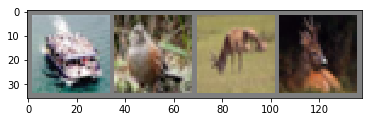

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
# show images
plt.figure()
My_imshow_image(torchvision.utils.make_grid(images[0:4,:,:,:]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
def My_imshow_noise(img):
    npimg = img.numpy().transpose((1,2,0))
    min_val = np.min(npimg, keepdims =True)
    print('min',min_val)
    max_val = np.max(npimg, keepdims =True)
    print('max',max_val)
    inp = (npimg-min_val)/(max_val-min_val)
   # inp = npimg
    plt.imshow(inp)

min [[[-1.]]]
max [[[1.]]]
 ship


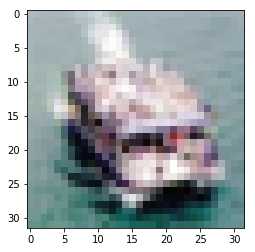

In [11]:
plt.figure()
My_imshow_noise(torchvision.utils.make_grid(images[0,:,:,:]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

min [[[0.]]]
max [[[0.9999961]]]
min [[[0.874004]]]
max [[[0.92339957]]]


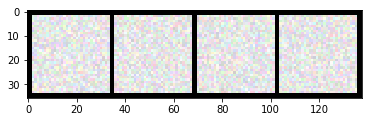

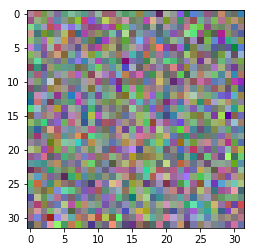

In [12]:
# Do not run this cell if you have already loaded a saved noise template and corresponding trained model file above
noise_input_conv = Variable(0.2*torch.rand(batch_size,3,32,32) +0.8 , requires_grad = True)
My_imshow_noise(torchvision.utils.make_grid(noise_input_conv.data[0:4,:,:,:]))
mean_noise_init=torch.mean(noise_input_conv,0,True)
plt.figure()
My_imshow_noise(mean_noise_init.data[0,:,:,:])

min [[[-0.09717631]]]
max [[[1.9092638]]]


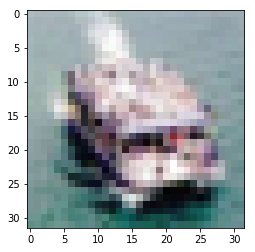

In [13]:
My_imshow_noise(torchvision.utils.make_grid(images[0,:,:,:]+(mean_noise_init.data[0,:,:,:])))

In [14]:
acc = Variable(torch.Tensor([0]))

In [15]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
lr_noise =Variable(torch.Tensor([0.001]))

In [16]:
def train(epoch):
    #running_loss = 0.0
    model.train()
    mean_noise_image = torch.mean(noise_input_conv, 0, True)
    My_imshow_noise(mean_noise_image.data[0,:,:,:])
    plt.ioff()
    plt.show()
    for batch_idx, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()
        bsize = inputs.size(0)
        # forward + backward + optimize
        outputs = model(inputs, noise_input_conv[0:bsize,:,:,:].cuda())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        noise_input_conv.data = noise_input_conv.data - lr_noise.data * np.multiply(noise_input_conv.grad.data<0, 
                                                                                    noise_input_conv.grad.data)
        # print statistics
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [17]:
def test():
    correct = 0
    total = 0
    test_loss = 0
    model.eval()
    for data in test_loader:
        images, labels = data
        inputs, target = Variable(images.cuda()),Variable(labels.cuda())
        mean_noise = torch.mean(noise_input_conv, 0, True)
        outputs = model(inputs, mean_noise.cuda())
        total += labels.size(0)
        test_loss += criterion(outputs, target).data[0]
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc.data = torch.Tensor([100. * correct / len(test_loader.dataset)])

min [[[0.874004]]]
max [[[0.92339957]]]


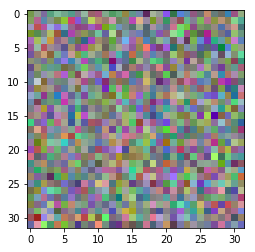

/data/pandap/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304025
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.631231
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.696650
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.623846
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.282711
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.481913
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.555597
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.348392


/data/pandap/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':



Test set: Average loss: 0.0207, Accuracy: 5319/10000 (53%)

min [[[0.87443495]]]
max [[[0.92410845]]]


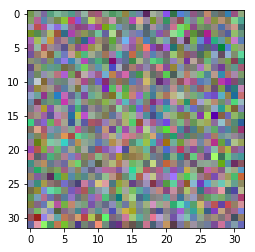

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.136222
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.978470
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.135389
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.041196
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.232324
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.866355
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.981065
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.824010

Test set: Average loss: 0.0166, Accuracy: 6298/10000 (62%)

min [[[0.8761316]]]
max [[[0.92748636]]]


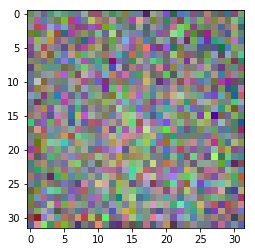

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.145933
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.016064
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.756066
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.678165
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.749646
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.831107
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.582893
Train Epoch: 3 [44800/50000 (90%)]	Loss: 0.829700

Test set: Average loss: 0.0136, Accuracy: 7004/10000 (70%)

min [[[0.879326]]]
max [[[0.93401957]]]


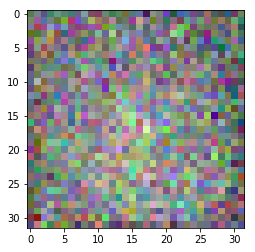

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.498168
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.582653
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.756762
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.529481
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.590598
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.633633
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.560630
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.721451

Test set: Average loss: 0.0124, Accuracy: 7256/10000 (72%)

min [[[0.8848102]]]
max [[[0.94847786]]]


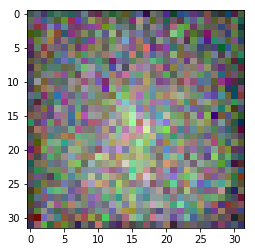

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.526848
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.583592
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.623595
Train Epoch: 5 [19200/50000 (38%)]	Loss: 0.637209
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.589999
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.693081
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.591833
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.481559

Test set: Average loss: 0.0107, Accuracy: 7712/10000 (77%)

min [[[0.88734704]]]
max [[[0.96615744]]]


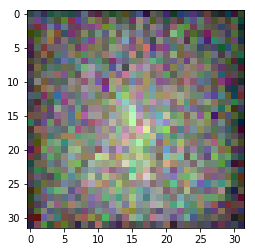

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.364080
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.588064
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.632329
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.592542
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.530920
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.533541
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.490618
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.397256

Test set: Average loss: 0.0110, Accuracy: 7667/10000 (76%)

min [[[0.88963366]]]
max [[[0.9839878]]]


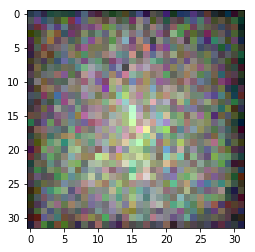

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.390702
Train Epoch: 7 [6400/50000 (13%)]	Loss: 0.743445
Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.495638
Train Epoch: 7 [19200/50000 (38%)]	Loss: 0.743132
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.554544
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.581625
Train Epoch: 7 [38400/50000 (77%)]	Loss: 0.879764
Train Epoch: 7 [44800/50000 (90%)]	Loss: 0.691212

Test set: Average loss: 0.0122, Accuracy: 7454/10000 (74%)

min [[[0.89187545]]]
max [[[1.0063663]]]


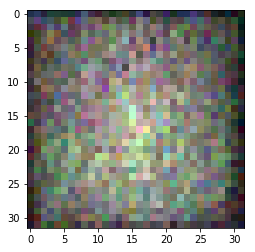

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.447272
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.465754
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.428467
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.610134
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.540794
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.598372
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.852121
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.562005

Test set: Average loss: 0.0115, Accuracy: 7572/10000 (75%)

min [[[0.8943788]]]
max [[[1.0301864]]]


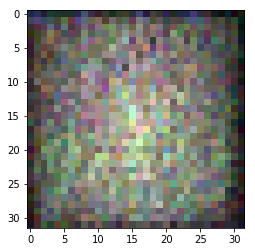

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.491658
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.400341
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.475981
Train Epoch: 9 [19200/50000 (38%)]	Loss: 0.391111
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.637524
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.639302
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.644341
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.578126

Test set: Average loss: 0.0120, Accuracy: 7499/10000 (74%)

min [[[0.89726555]]]
max [[[1.0556061]]]


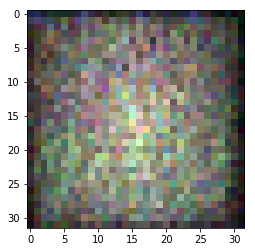

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.525772
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.211935
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.375209
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.597712
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.699196
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.739132
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.467600
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.540970

Test set: Average loss: 0.0114, Accuracy: 7603/10000 (76%)

min [[[0.89961284]]]
max [[[1.081387]]]


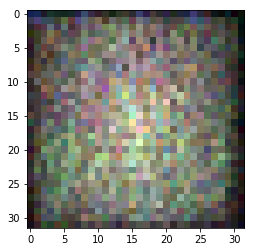

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.531780
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.388834
Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.479975
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.479576
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.400066
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.474016
Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.558687
Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.333831

Test set: Average loss: 0.0127, Accuracy: 7335/10000 (73%)

min [[[0.9022047]]]
max [[[1.11569]]]


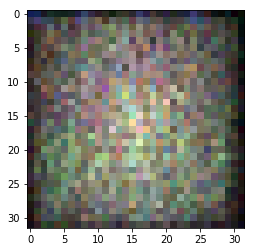

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.443445
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.381857
Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.459743
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.356365
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.341616
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.408667
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.565530
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.429675

Test set: Average loss: 0.0093, Accuracy: 7998/10000 (79%)

min [[[0.9044546]]]
max [[[1.1490809]]]


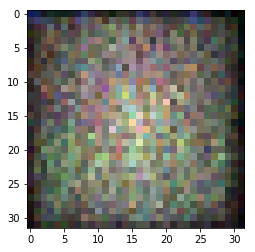

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.412490
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.375373
Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.474710
Train Epoch: 13 [19200/50000 (38%)]	Loss: 0.410378
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.490715
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.603559
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.567043
Train Epoch: 13 [44800/50000 (90%)]	Loss: 0.562136

Test set: Average loss: 0.0109, Accuracy: 7666/10000 (76%)

min [[[0.90668935]]]
max [[[1.1819104]]]


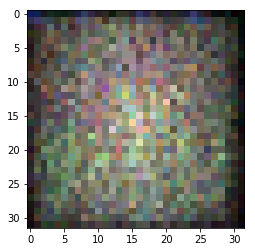

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.499820
Train Epoch: 14 [6400/50000 (13%)]	Loss: 0.281123
Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.524715
Train Epoch: 14 [19200/50000 (38%)]	Loss: 0.429394
Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.566264
Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.441834
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.492284
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.633256

Test set: Average loss: 0.0107, Accuracy: 7763/10000 (77%)

min [[[0.90903896]]]
max [[[1.2160892]]]


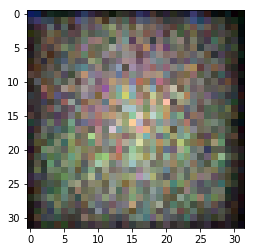

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.342287
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.310485
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.440970
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.613182
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.406443
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.627561
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.324634
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.401549

Test set: Average loss: 0.0116, Accuracy: 7497/10000 (74%)

min [[[0.9115157]]]
max [[[1.2505555]]]


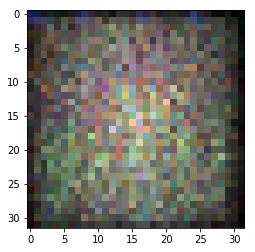

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.407577
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.422628
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.615400
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.570686
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.520894
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.623218
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.443322
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.398438

Test set: Average loss: 0.0110, Accuracy: 7680/10000 (76%)

min [[[0.9141015]]]
max [[[1.2849728]]]


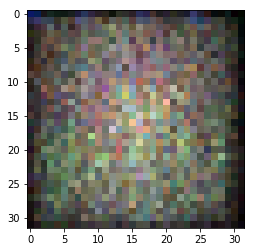

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.260030
Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.295566
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.365580
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.560947
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.362425
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.615953
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.495481
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.521168

Test set: Average loss: 0.0106, Accuracy: 7786/10000 (77%)

min [[[0.91642994]]]
max [[[1.319346]]]


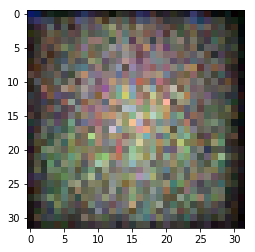

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.285144
Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.353864
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.500508
Train Epoch: 18 [19200/50000 (38%)]	Loss: 0.327080
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.455932
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.399624
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.701141
Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.407714

Test set: Average loss: 0.0119, Accuracy: 7511/10000 (75%)

min [[[0.9181605]]]
max [[[1.3558732]]]


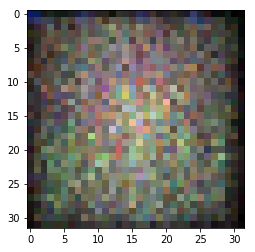

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.457170
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.353022
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.413456
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.507155
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.699735
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.563540
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.405216
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.455863

Test set: Average loss: 0.0127, Accuracy: 7386/10000 (73%)

min [[[0.91996115]]]
max [[[1.3919252]]]


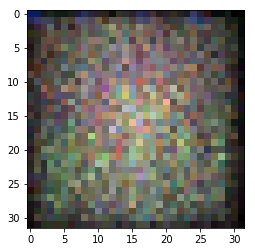

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.721037
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.251433
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.385598
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.475217
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.620435
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.232240
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.562737
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.521194

Test set: Average loss: 0.0158, Accuracy: 6690/10000 (66%)

min [[[0.92180824]]]
max [[[1.4262073]]]


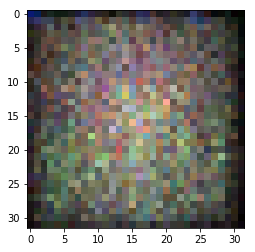

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.285262
Train Epoch: 21 [6400/50000 (13%)]	Loss: 0.418405
Train Epoch: 21 [12800/50000 (26%)]	Loss: 0.312872
Train Epoch: 21 [19200/50000 (38%)]	Loss: 0.321538
Train Epoch: 21 [25600/50000 (51%)]	Loss: 0.815636
Train Epoch: 21 [32000/50000 (64%)]	Loss: 0.563954
Train Epoch: 21 [38400/50000 (77%)]	Loss: 0.368173
Train Epoch: 21 [44800/50000 (90%)]	Loss: 0.456954

Test set: Average loss: 0.0118, Accuracy: 7582/10000 (75%)

min [[[0.92379797]]]
max [[[1.4581932]]]


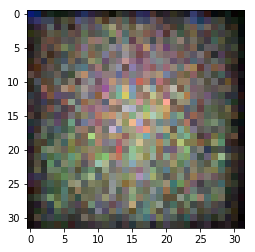

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.386178
Train Epoch: 22 [6400/50000 (13%)]	Loss: 0.485703
Train Epoch: 22 [12800/50000 (26%)]	Loss: 0.397029
Train Epoch: 22 [19200/50000 (38%)]	Loss: 0.534093
Train Epoch: 22 [25600/50000 (51%)]	Loss: 0.409307
Train Epoch: 22 [32000/50000 (64%)]	Loss: 0.475669
Train Epoch: 22 [38400/50000 (77%)]	Loss: 0.744858
Train Epoch: 22 [44800/50000 (90%)]	Loss: 0.502201

Test set: Average loss: 0.0110, Accuracy: 7763/10000 (77%)

min [[[0.92587686]]]
max [[[1.4895183]]]


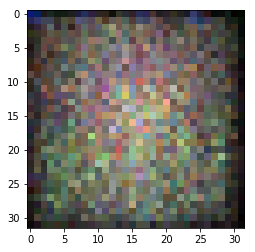

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.386905
Train Epoch: 23 [6400/50000 (13%)]	Loss: 0.474673
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.297225
Train Epoch: 23 [19200/50000 (38%)]	Loss: 0.516724
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.347970
Train Epoch: 23 [32000/50000 (64%)]	Loss: 0.563695
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.402891
Train Epoch: 23 [44800/50000 (90%)]	Loss: 0.270328

Test set: Average loss: 0.0098, Accuracy: 7899/10000 (78%)

min [[[0.9281148]]]
max [[[1.5219995]]]


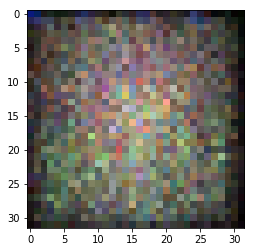

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.469968
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.414051
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.315284
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.424876
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.303446
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.427682
Train Epoch: 24 [38400/50000 (77%)]	Loss: 0.446006
Train Epoch: 24 [44800/50000 (90%)]	Loss: 0.314817

Test set: Average loss: 0.0104, Accuracy: 7806/10000 (78%)

min [[[0.9304349]]]
max [[[1.5550636]]]


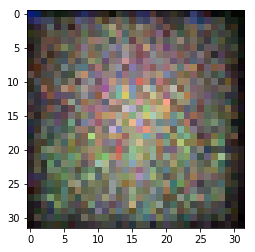

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.625145
Train Epoch: 25 [6400/50000 (13%)]	Loss: 0.291626
Train Epoch: 25 [12800/50000 (26%)]	Loss: 0.353036
Train Epoch: 25 [19200/50000 (38%)]	Loss: 0.387793
Train Epoch: 25 [25600/50000 (51%)]	Loss: 0.419805
Train Epoch: 25 [32000/50000 (64%)]	Loss: 0.430389
Train Epoch: 25 [38400/50000 (77%)]	Loss: 0.298356
Train Epoch: 25 [44800/50000 (90%)]	Loss: 0.605406

Test set: Average loss: 0.0104, Accuracy: 7740/10000 (77%)

min [[[0.9328371]]]
max [[[1.5883949]]]


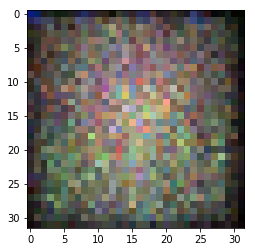

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.345676
Train Epoch: 26 [6400/50000 (13%)]	Loss: 0.219302
Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.468651
Train Epoch: 26 [19200/50000 (38%)]	Loss: 0.432464
Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.482650
Train Epoch: 26 [32000/50000 (64%)]	Loss: 0.445831
Train Epoch: 26 [38400/50000 (77%)]	Loss: 0.497464
Train Epoch: 26 [44800/50000 (90%)]	Loss: 0.276583

Test set: Average loss: 0.0170, Accuracy: 6905/10000 (69%)

min [[[0.9354457]]]
max [[[1.6225724]]]


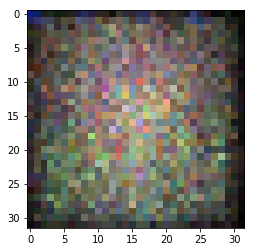

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.327789
Train Epoch: 27 [6400/50000 (13%)]	Loss: 0.486123
Train Epoch: 27 [12800/50000 (26%)]	Loss: 0.219437
Train Epoch: 27 [19200/50000 (38%)]	Loss: 0.563595
Train Epoch: 27 [25600/50000 (51%)]	Loss: 0.458449
Train Epoch: 27 [32000/50000 (64%)]	Loss: 0.457264
Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.580669
Train Epoch: 27 [44800/50000 (90%)]	Loss: 0.576906

Test set: Average loss: 0.0096, Accuracy: 7953/10000 (79%)

min [[[0.93807423]]]
max [[[1.656967]]]


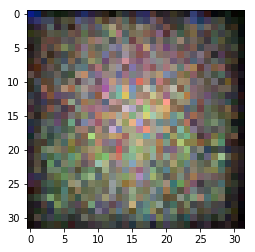

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.478659
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.643119
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.450590
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.563675
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.431035
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.488114
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.569241
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.567302

Test set: Average loss: 0.0099, Accuracy: 7899/10000 (78%)

min [[[0.94068503]]]
max [[[1.691158]]]


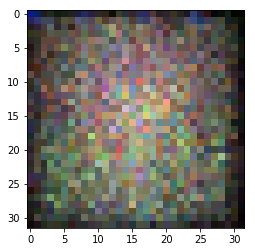

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.464832
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.353620
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.324437
Train Epoch: 29 [19200/50000 (38%)]	Loss: 0.478785
Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.245909
Train Epoch: 29 [32000/50000 (64%)]	Loss: 0.508300
Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.720764
Train Epoch: 29 [44800/50000 (90%)]	Loss: 0.438148

Test set: Average loss: 0.0106, Accuracy: 7783/10000 (77%)

min [[[0.9433698]]]
max [[[1.7249678]]]


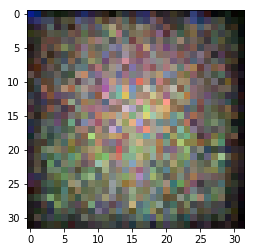

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.373361
Train Epoch: 30 [6400/50000 (13%)]	Loss: 0.374521
Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.331664
Train Epoch: 30 [19200/50000 (38%)]	Loss: 0.464983
Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.478978
Train Epoch: 30 [32000/50000 (64%)]	Loss: 0.680898
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.210686
Train Epoch: 30 [44800/50000 (90%)]	Loss: 0.396110

Test set: Average loss: 0.0109, Accuracy: 7753/10000 (77%)

min [[[0.94612616]]]
max [[[1.7575275]]]


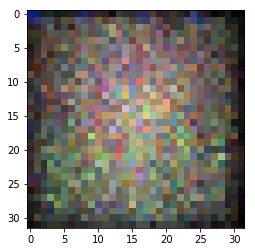

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.539525
Train Epoch: 31 [6400/50000 (13%)]	Loss: 0.191049
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.199368
Train Epoch: 31 [19200/50000 (38%)]	Loss: 0.251080
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.539495
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.199270
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.188467
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.130693

Test set: Average loss: 0.0066, Accuracy: 8627/10000 (86%)

min [[[0.94640833]]]
max [[[1.760713]]]


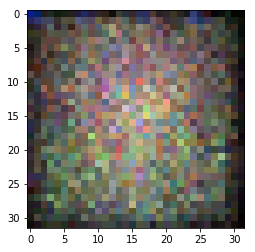

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.095073
Train Epoch: 32 [6400/50000 (13%)]	Loss: 0.117074
Train Epoch: 32 [12800/50000 (26%)]	Loss: 0.113901
Train Epoch: 32 [19200/50000 (38%)]	Loss: 0.051453
Train Epoch: 32 [25600/50000 (51%)]	Loss: 0.088222
Train Epoch: 32 [32000/50000 (64%)]	Loss: 0.058888
Train Epoch: 32 [38400/50000 (77%)]	Loss: 0.033989
Train Epoch: 32 [44800/50000 (90%)]	Loss: 0.069178

Test set: Average loss: 0.0069, Accuracy: 8650/10000 (86%)

min [[[0.9466872]]]
max [[[1.7638727]]]


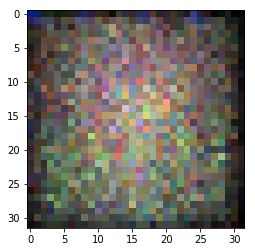

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.060247
Train Epoch: 33 [6400/50000 (13%)]	Loss: 0.058908
Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.034308
Train Epoch: 33 [19200/50000 (38%)]	Loss: 0.059913
Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.020555
Train Epoch: 33 [32000/50000 (64%)]	Loss: 0.039188
Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.076051
Train Epoch: 33 [44800/50000 (90%)]	Loss: 0.024931

Test set: Average loss: 0.0073, Accuracy: 8679/10000 (86%)

min [[[0.9469579]]]
max [[[1.7669832]]]


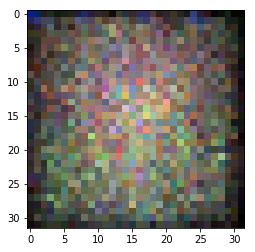

Train Epoch: 34 [0/50000 (0%)]	Loss: 0.024285
Train Epoch: 34 [6400/50000 (13%)]	Loss: 0.117090
Train Epoch: 34 [12800/50000 (26%)]	Loss: 0.018292
Train Epoch: 34 [19200/50000 (38%)]	Loss: 0.038249
Train Epoch: 34 [25600/50000 (51%)]	Loss: 0.010380
Train Epoch: 34 [32000/50000 (64%)]	Loss: 0.036604
Train Epoch: 34 [38400/50000 (77%)]	Loss: 0.019933
Train Epoch: 34 [44800/50000 (90%)]	Loss: 0.019398

Test set: Average loss: 0.0075, Accuracy: 8691/10000 (86%)

min [[[0.9472197]]]
max [[[1.7700456]]]


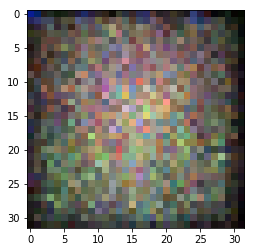

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.030422
Train Epoch: 35 [6400/50000 (13%)]	Loss: 0.011581
Train Epoch: 35 [12800/50000 (26%)]	Loss: 0.019188
Train Epoch: 35 [19200/50000 (38%)]	Loss: 0.011612
Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.005753
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.011862
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.024533
Train Epoch: 35 [44800/50000 (90%)]	Loss: 0.015312

Test set: Average loss: 0.0079, Accuracy: 8654/10000 (86%)

min [[[0.94747996]]]
max [[[1.773122]]]


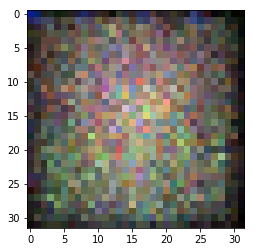

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.008962
Train Epoch: 36 [6400/50000 (13%)]	Loss: 0.025893
Train Epoch: 36 [12800/50000 (26%)]	Loss: 0.003355
Train Epoch: 36 [19200/50000 (38%)]	Loss: 0.013047
Train Epoch: 36 [25600/50000 (51%)]	Loss: 0.004231
Train Epoch: 36 [32000/50000 (64%)]	Loss: 0.008477
Train Epoch: 36 [38400/50000 (77%)]	Loss: 0.009325
Train Epoch: 36 [44800/50000 (90%)]	Loss: 0.004032

Test set: Average loss: 0.0079, Accuracy: 8666/10000 (86%)

min [[[0.94774675]]]
max [[[1.7762134]]]


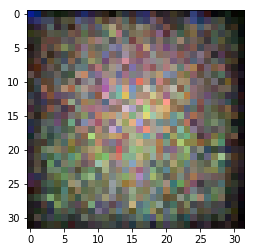

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.014122
Train Epoch: 37 [6400/50000 (13%)]	Loss: 0.022092
Train Epoch: 37 [12800/50000 (26%)]	Loss: 0.022261
Train Epoch: 37 [19200/50000 (38%)]	Loss: 0.003520
Train Epoch: 37 [25600/50000 (51%)]	Loss: 0.006244
Train Epoch: 37 [32000/50000 (64%)]	Loss: 0.039208
Train Epoch: 37 [38400/50000 (77%)]	Loss: 0.022358
Train Epoch: 37 [44800/50000 (90%)]	Loss: 0.010186

Test set: Average loss: 0.0080, Accuracy: 8679/10000 (86%)

min [[[0.948015]]]
max [[[1.7792857]]]


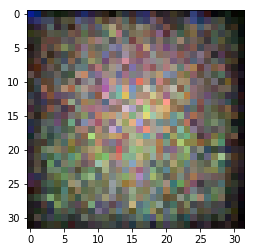

Train Epoch: 38 [0/50000 (0%)]	Loss: 0.008382
Train Epoch: 38 [6400/50000 (13%)]	Loss: 0.009569
Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.006636
Train Epoch: 38 [19200/50000 (38%)]	Loss: 0.011839
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.011417
Train Epoch: 38 [32000/50000 (64%)]	Loss: 0.004692
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.005119
Train Epoch: 38 [44800/50000 (90%)]	Loss: 0.004619

Test set: Average loss: 0.0082, Accuracy: 8635/10000 (86%)

min [[[0.9482786]]]
max [[[1.782375]]]


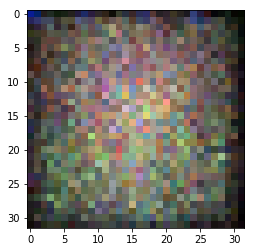

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.004009
Train Epoch: 39 [6400/50000 (13%)]	Loss: 0.003272
Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.003177
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.016383
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.003987
Train Epoch: 39 [32000/50000 (64%)]	Loss: 0.004669
Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.007035
Train Epoch: 39 [44800/50000 (90%)]	Loss: 0.005154

Test set: Average loss: 0.0079, Accuracy: 8695/10000 (86%)

min [[[0.94854206]]]
max [[[1.7854534]]]


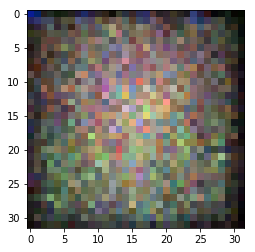

Train Epoch: 40 [0/50000 (0%)]	Loss: 0.003914
Train Epoch: 40 [6400/50000 (13%)]	Loss: 0.005403
Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.014709
Train Epoch: 40 [19200/50000 (38%)]	Loss: 0.031425
Train Epoch: 40 [25600/50000 (51%)]	Loss: 0.005541
Train Epoch: 40 [32000/50000 (64%)]	Loss: 0.002155
Train Epoch: 40 [38400/50000 (77%)]	Loss: 0.004252
Train Epoch: 40 [44800/50000 (90%)]	Loss: 0.002053

Test set: Average loss: 0.0080, Accuracy: 8682/10000 (86%)

min [[[0.94880444]]]
max [[[1.7885568]]]


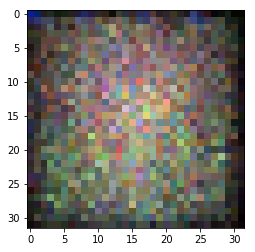

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.007721
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.005399
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.002437
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.008806
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.004040
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.007828
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.002900
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.004932

Test set: Average loss: 0.0084, Accuracy: 8620/10000 (86%)

min [[[0.94906586]]]
max [[[1.7916412]]]


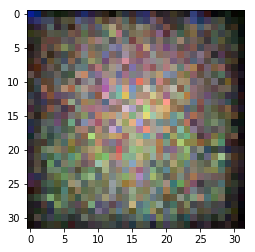

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.004428
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.003976
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.012355
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.007338
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.004134
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.005503
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.003770
Train Epoch: 42 [44800/50000 (90%)]	Loss: 0.074150

Test set: Average loss: 0.0078, Accuracy: 8714/10000 (87%)

min [[[0.94933045]]]
max [[[1.7947174]]]


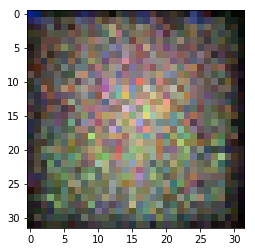

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.002472
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.007173
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.022315
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.002312
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.001884
Train Epoch: 43 [32000/50000 (64%)]	Loss: 0.026256
Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.002185
Train Epoch: 43 [44800/50000 (90%)]	Loss: 0.017717

Test set: Average loss: 0.0082, Accuracy: 8644/10000 (86%)

min [[[0.9496009]]]
max [[[1.7978071]]]


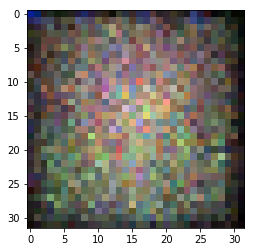

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.022781
Train Epoch: 44 [6400/50000 (13%)]	Loss: 0.005622
Train Epoch: 44 [12800/50000 (26%)]	Loss: 0.003795
Train Epoch: 44 [19200/50000 (38%)]	Loss: 0.047403
Train Epoch: 44 [25600/50000 (51%)]	Loss: 0.005725
Train Epoch: 44 [32000/50000 (64%)]	Loss: 0.003050
Train Epoch: 44 [38400/50000 (77%)]	Loss: 0.004136
Train Epoch: 44 [44800/50000 (90%)]	Loss: 0.004600

Test set: Average loss: 0.0081, Accuracy: 8660/10000 (86%)

min [[[0.9498725]]]
max [[[1.800895]]]


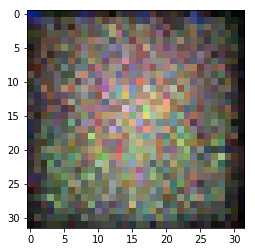

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.005026
Train Epoch: 45 [6400/50000 (13%)]	Loss: 0.006339
Train Epoch: 45 [12800/50000 (26%)]	Loss: 0.008441
Train Epoch: 45 [19200/50000 (38%)]	Loss: 0.026488
Train Epoch: 45 [25600/50000 (51%)]	Loss: 0.008289
Train Epoch: 45 [32000/50000 (64%)]	Loss: 0.003460
Train Epoch: 45 [38400/50000 (77%)]	Loss: 0.027002
Train Epoch: 45 [44800/50000 (90%)]	Loss: 0.024370

Test set: Average loss: 0.0092, Accuracy: 8478/10000 (84%)

min [[[0.9501465]]]
max [[[1.8039917]]]


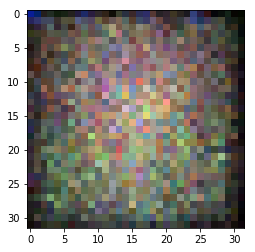

Train Epoch: 46 [0/50000 (0%)]	Loss: 0.031926
Train Epoch: 46 [6400/50000 (13%)]	Loss: 0.004635
Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.005535
Train Epoch: 46 [19200/50000 (38%)]	Loss: 0.008839
Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.063099
Train Epoch: 46 [32000/50000 (64%)]	Loss: 0.029137
Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.016956
Train Epoch: 46 [44800/50000 (90%)]	Loss: 0.019203

Test set: Average loss: 0.0089, Accuracy: 8550/10000 (85%)

min [[[0.95042235]]]
max [[[1.8070924]]]


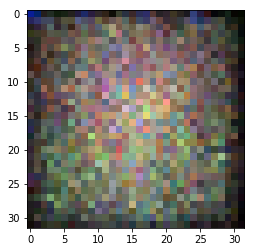

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.008073
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.003777
Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.011011
Train Epoch: 47 [19200/50000 (38%)]	Loss: 0.007540
Train Epoch: 47 [25600/50000 (51%)]	Loss: 0.010522
Train Epoch: 47 [32000/50000 (64%)]	Loss: 0.028307
Train Epoch: 47 [38400/50000 (77%)]	Loss: 0.011773
Train Epoch: 47 [44800/50000 (90%)]	Loss: 0.012807

Test set: Average loss: 0.0102, Accuracy: 8366/10000 (83%)

min [[[0.9506991]]]
max [[[1.8102065]]]


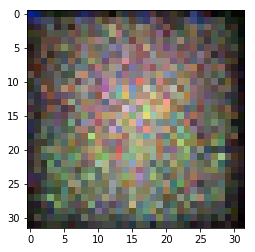

Train Epoch: 48 [0/50000 (0%)]	Loss: 0.022636
Train Epoch: 48 [6400/50000 (13%)]	Loss: 0.067417
Train Epoch: 48 [12800/50000 (26%)]	Loss: 0.012083
Train Epoch: 48 [19200/50000 (38%)]	Loss: 0.011907
Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.015607
Train Epoch: 48 [32000/50000 (64%)]	Loss: 0.079964
Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.066663
Train Epoch: 48 [44800/50000 (90%)]	Loss: 0.103505

Test set: Average loss: 0.0089, Accuracy: 8499/10000 (84%)

min [[[0.9509799]]]
max [[[1.8133457]]]


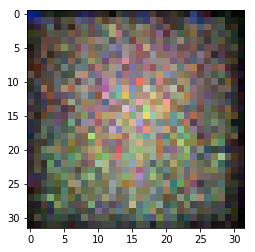

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.023574
Train Epoch: 49 [6400/50000 (13%)]	Loss: 0.099323
Train Epoch: 49 [12800/50000 (26%)]	Loss: 0.025211
Train Epoch: 49 [19200/50000 (38%)]	Loss: 0.054090
Train Epoch: 49 [25600/50000 (51%)]	Loss: 0.024544
Train Epoch: 49 [32000/50000 (64%)]	Loss: 0.020658
Train Epoch: 49 [38400/50000 (77%)]	Loss: 0.021589
Train Epoch: 49 [44800/50000 (90%)]	Loss: 0.136171

Test set: Average loss: 0.0107, Accuracy: 8214/10000 (82%)

min [[[0.9512583]]]
max [[[1.8165029]]]


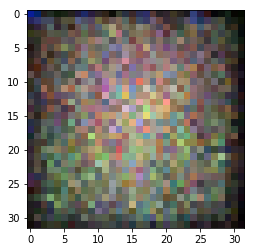

Train Epoch: 50 [0/50000 (0%)]	Loss: 0.018646
Train Epoch: 50 [6400/50000 (13%)]	Loss: 0.082657
Train Epoch: 50 [12800/50000 (26%)]	Loss: 0.029572
Train Epoch: 50 [19200/50000 (38%)]	Loss: 0.010353
Train Epoch: 50 [25600/50000 (51%)]	Loss: 0.063152
Train Epoch: 50 [32000/50000 (64%)]	Loss: 0.105101
Train Epoch: 50 [38400/50000 (77%)]	Loss: 0.028733
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.132539

Test set: Average loss: 0.0099, Accuracy: 8285/10000 (82%)

min [[[0.951535]]]
max [[[1.8197367]]]


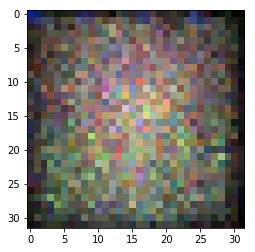

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.060706
Train Epoch: 51 [6400/50000 (13%)]	Loss: 0.034730
Train Epoch: 51 [12800/50000 (26%)]	Loss: 0.058446
Train Epoch: 51 [19200/50000 (38%)]	Loss: 0.021720
Train Epoch: 51 [25600/50000 (51%)]	Loss: 0.087671
Train Epoch: 51 [32000/50000 (64%)]	Loss: 0.059540
Train Epoch: 51 [38400/50000 (77%)]	Loss: 0.058540
Train Epoch: 51 [44800/50000 (90%)]	Loss: 0.045435

Test set: Average loss: 0.0091, Accuracy: 8460/10000 (84%)

min [[[0.9518063]]]
max [[[1.8229748]]]


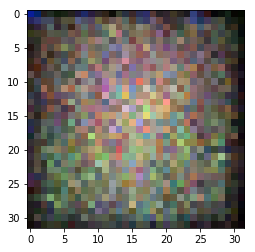

Train Epoch: 52 [0/50000 (0%)]	Loss: 0.005419
Train Epoch: 52 [6400/50000 (13%)]	Loss: 0.022410
Train Epoch: 52 [12800/50000 (26%)]	Loss: 0.029768
Train Epoch: 52 [19200/50000 (38%)]	Loss: 0.013681
Train Epoch: 52 [25600/50000 (51%)]	Loss: 0.064903
Train Epoch: 52 [32000/50000 (64%)]	Loss: 0.041241
Train Epoch: 52 [38400/50000 (77%)]	Loss: 0.027764
Train Epoch: 52 [44800/50000 (90%)]	Loss: 0.130266

Test set: Average loss: 0.0093, Accuracy: 8391/10000 (83%)

min [[[0.95208824]]]
max [[[1.8262223]]]


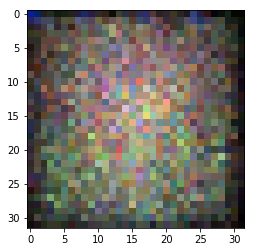

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.034744
Train Epoch: 53 [6400/50000 (13%)]	Loss: 0.004104
Train Epoch: 53 [12800/50000 (26%)]	Loss: 0.019625
Train Epoch: 53 [19200/50000 (38%)]	Loss: 0.012036
Train Epoch: 53 [25600/50000 (51%)]	Loss: 0.005473
Train Epoch: 53 [32000/50000 (64%)]	Loss: 0.040118
Train Epoch: 53 [38400/50000 (77%)]	Loss: 0.101815
Train Epoch: 53 [44800/50000 (90%)]	Loss: 0.052657

Test set: Average loss: 0.0091, Accuracy: 8437/10000 (84%)

min [[[0.9523847]]]
max [[[1.8294947]]]


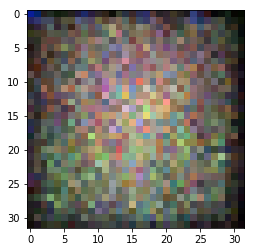

Train Epoch: 54 [0/50000 (0%)]	Loss: 0.103102
Train Epoch: 54 [6400/50000 (13%)]	Loss: 0.010711
Train Epoch: 54 [12800/50000 (26%)]	Loss: 0.033175
Train Epoch: 54 [19200/50000 (38%)]	Loss: 0.028180
Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.019671
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.061072
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.036607
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.037001

Test set: Average loss: 0.0106, Accuracy: 8273/10000 (82%)

min [[[0.95268875]]]
max [[[1.8327587]]]


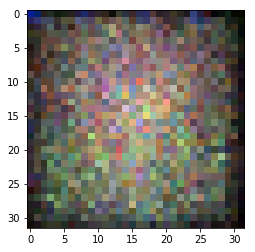

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.033116
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.107255
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.032022
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.020518
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.037384
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.006656
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.040368
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.059837

Test set: Average loss: 0.0096, Accuracy: 8357/10000 (83%)

min [[[0.95299673]]]
max [[[1.8360925]]]


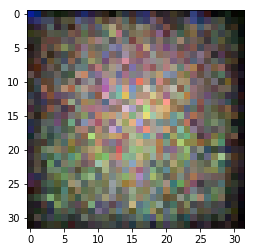

Train Epoch: 56 [0/50000 (0%)]	Loss: 0.052788
Train Epoch: 56 [6400/50000 (13%)]	Loss: 0.035157
Train Epoch: 56 [12800/50000 (26%)]	Loss: 0.060664
Train Epoch: 56 [19200/50000 (38%)]	Loss: 0.034189
Train Epoch: 56 [25600/50000 (51%)]	Loss: 0.085175
Train Epoch: 56 [32000/50000 (64%)]	Loss: 0.045988
Train Epoch: 56 [38400/50000 (77%)]	Loss: 0.086363
Train Epoch: 56 [44800/50000 (90%)]	Loss: 0.075473

Test set: Average loss: 0.0102, Accuracy: 8273/10000 (82%)

min [[[0.95330346]]]
max [[[1.8394754]]]


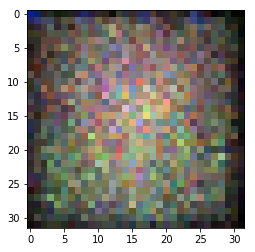

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.049219
Train Epoch: 57 [6400/50000 (13%)]	Loss: 0.031930
Train Epoch: 57 [12800/50000 (26%)]	Loss: 0.083027
Train Epoch: 57 [19200/50000 (38%)]	Loss: 0.050197
Train Epoch: 57 [25600/50000 (51%)]	Loss: 0.034135
Train Epoch: 57 [32000/50000 (64%)]	Loss: 0.004659
Train Epoch: 57 [38400/50000 (77%)]	Loss: 0.088313
Train Epoch: 57 [44800/50000 (90%)]	Loss: 0.028969

Test set: Average loss: 0.0101, Accuracy: 8337/10000 (83%)

min [[[0.95361376]]]
max [[[1.8428531]]]


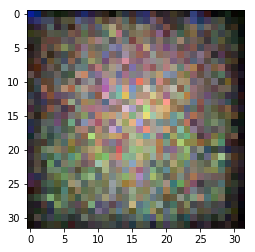

Train Epoch: 58 [0/50000 (0%)]	Loss: 0.028809
Train Epoch: 58 [6400/50000 (13%)]	Loss: 0.020570
Train Epoch: 58 [12800/50000 (26%)]	Loss: 0.015316
Train Epoch: 58 [19200/50000 (38%)]	Loss: 0.013041
Train Epoch: 58 [25600/50000 (51%)]	Loss: 0.058853
Train Epoch: 58 [32000/50000 (64%)]	Loss: 0.064979
Train Epoch: 58 [38400/50000 (77%)]	Loss: 0.048970
Train Epoch: 58 [44800/50000 (90%)]	Loss: 0.020529

Test set: Average loss: 0.0099, Accuracy: 8364/10000 (83%)

min [[[0.95392853]]]
max [[[1.8462392]]]


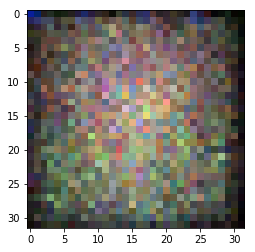

Train Epoch: 59 [0/50000 (0%)]	Loss: 0.032585
Train Epoch: 59 [6400/50000 (13%)]	Loss: 0.015237
Train Epoch: 59 [12800/50000 (26%)]	Loss: 0.030065
Train Epoch: 59 [19200/50000 (38%)]	Loss: 0.017977
Train Epoch: 59 [25600/50000 (51%)]	Loss: 0.008356
Train Epoch: 59 [32000/50000 (64%)]	Loss: 0.019265
Train Epoch: 59 [38400/50000 (77%)]	Loss: 0.021282
Train Epoch: 59 [44800/50000 (90%)]	Loss: 0.025417

Test set: Average loss: 0.0093, Accuracy: 8458/10000 (84%)

min [[[0.954242]]]
max [[[1.8496021]]]


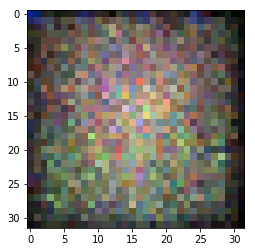

Train Epoch: 60 [0/50000 (0%)]	Loss: 0.009641
Train Epoch: 60 [6400/50000 (13%)]	Loss: 0.032525
Train Epoch: 60 [12800/50000 (26%)]	Loss: 0.009613
Train Epoch: 60 [19200/50000 (38%)]	Loss: 0.044906
Train Epoch: 60 [25600/50000 (51%)]	Loss: 0.051121
Train Epoch: 60 [32000/50000 (64%)]	Loss: 0.011396
Train Epoch: 60 [38400/50000 (77%)]	Loss: 0.069313
Train Epoch: 60 [44800/50000 (90%)]	Loss: 0.075377

Test set: Average loss: 0.0103, Accuracy: 8343/10000 (83%)

min [[[0.95455116]]]
max [[[1.8529396]]]


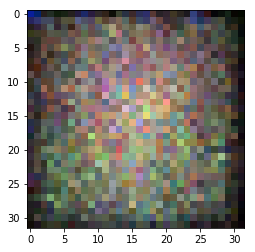

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.042482
Train Epoch: 61 [6400/50000 (13%)]	Loss: 0.036543
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.008537
Train Epoch: 61 [19200/50000 (38%)]	Loss: 0.025454
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.001925
Train Epoch: 61 [32000/50000 (64%)]	Loss: 0.003530
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.005707
Train Epoch: 61 [44800/50000 (90%)]	Loss: 0.007248

Test set: Average loss: 0.0084, Accuracy: 8579/10000 (85%)

min [[[0.9545818]]]
max [[[1.8532712]]]


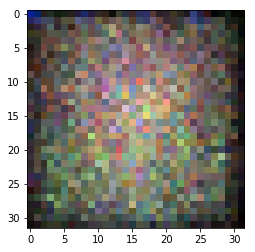

Train Epoch: 62 [0/50000 (0%)]	Loss: 0.001769
Train Epoch: 62 [6400/50000 (13%)]	Loss: 0.011063
Train Epoch: 62 [12800/50000 (26%)]	Loss: 0.006653
Train Epoch: 62 [19200/50000 (38%)]	Loss: 0.003007
Train Epoch: 62 [25600/50000 (51%)]	Loss: 0.008448
Train Epoch: 62 [32000/50000 (64%)]	Loss: 0.008223
Train Epoch: 62 [38400/50000 (77%)]	Loss: 0.005883
Train Epoch: 62 [44800/50000 (90%)]	Loss: 0.001743

Test set: Average loss: 0.0082, Accuracy: 8606/10000 (86%)

min [[[0.95461303]]]
max [[[1.8536063]]]


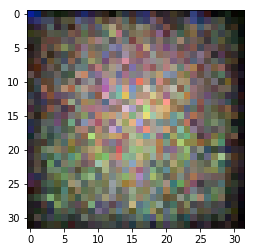

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.006954
Train Epoch: 63 [6400/50000 (13%)]	Loss: 0.002191
Train Epoch: 63 [12800/50000 (26%)]	Loss: 0.016561
Train Epoch: 63 [19200/50000 (38%)]	Loss: 0.011284
Train Epoch: 63 [25600/50000 (51%)]	Loss: 0.002539
Train Epoch: 63 [32000/50000 (64%)]	Loss: 0.000959
Train Epoch: 63 [38400/50000 (77%)]	Loss: 0.003287
Train Epoch: 63 [44800/50000 (90%)]	Loss: 0.003552

Test set: Average loss: 0.0081, Accuracy: 8601/10000 (86%)

min [[[0.9546444]]]
max [[[1.853941]]]


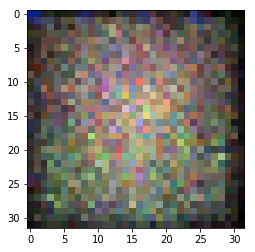

Train Epoch: 64 [0/50000 (0%)]	Loss: 0.003130
Train Epoch: 64 [6400/50000 (13%)]	Loss: 0.019293
Train Epoch: 64 [12800/50000 (26%)]	Loss: 0.001765
Train Epoch: 64 [19200/50000 (38%)]	Loss: 0.003995
Train Epoch: 64 [25600/50000 (51%)]	Loss: 0.004502
Train Epoch: 64 [32000/50000 (64%)]	Loss: 0.004069
Train Epoch: 64 [38400/50000 (77%)]	Loss: 0.011776
Train Epoch: 64 [44800/50000 (90%)]	Loss: 0.002511

Test set: Average loss: 0.0079, Accuracy: 8620/10000 (86%)

min [[[0.9546758]]]
max [[[1.8542747]]]


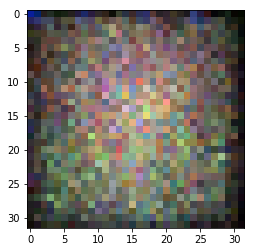

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.000990
Train Epoch: 65 [6400/50000 (13%)]	Loss: 0.001436
Train Epoch: 65 [12800/50000 (26%)]	Loss: 0.004149
Train Epoch: 65 [19200/50000 (38%)]	Loss: 0.002414
Train Epoch: 65 [25600/50000 (51%)]	Loss: 0.001576
Train Epoch: 65 [32000/50000 (64%)]	Loss: 0.002330
Train Epoch: 65 [38400/50000 (77%)]	Loss: 0.001117
Train Epoch: 65 [44800/50000 (90%)]	Loss: 0.003150

Test set: Average loss: 0.0082, Accuracy: 8620/10000 (86%)

min [[[0.9547073]]]
max [[[1.854607]]]


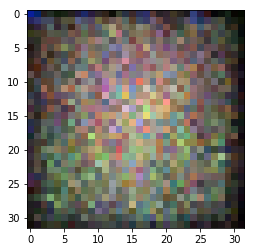

Train Epoch: 66 [0/50000 (0%)]	Loss: 0.004886
Train Epoch: 66 [6400/50000 (13%)]	Loss: 0.003025
Train Epoch: 66 [12800/50000 (26%)]	Loss: 0.001678
Train Epoch: 66 [19200/50000 (38%)]	Loss: 0.001535
Train Epoch: 66 [25600/50000 (51%)]	Loss: 0.002427
Train Epoch: 66 [32000/50000 (64%)]	Loss: 0.002970
Train Epoch: 66 [38400/50000 (77%)]	Loss: 0.002025
Train Epoch: 66 [44800/50000 (90%)]	Loss: 0.005563

Test set: Average loss: 0.0082, Accuracy: 8618/10000 (86%)

min [[[0.9547394]]]
max [[[1.8549381]]]


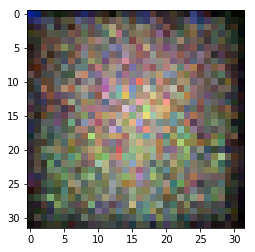

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.003660
Train Epoch: 67 [6400/50000 (13%)]	Loss: 0.004179
Train Epoch: 67 [12800/50000 (26%)]	Loss: 0.002565
Train Epoch: 67 [19200/50000 (38%)]	Loss: 0.002045
Train Epoch: 67 [25600/50000 (51%)]	Loss: 0.003413
Train Epoch: 67 [32000/50000 (64%)]	Loss: 0.001487
Train Epoch: 67 [38400/50000 (77%)]	Loss: 0.001954
Train Epoch: 67 [44800/50000 (90%)]	Loss: 0.001706

Test set: Average loss: 0.0080, Accuracy: 8642/10000 (86%)

min [[[0.95476985]]]
max [[[1.8552673]]]


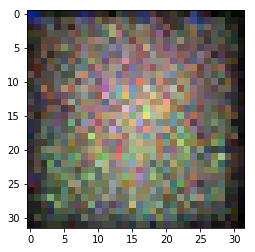

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.001401
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.003321
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.006815
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.002842
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.001840
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.001804
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.001537
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.002237

Test set: Average loss: 0.0079, Accuracy: 8638/10000 (86%)

min [[[0.954801]]]
max [[[1.8555968]]]


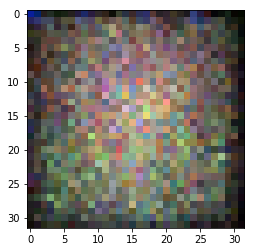

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.002134
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.001397
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.004260
Train Epoch: 69 [19200/50000 (38%)]	Loss: 0.000922
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.000970
Train Epoch: 69 [32000/50000 (64%)]	Loss: 0.003924
Train Epoch: 69 [38400/50000 (77%)]	Loss: 0.002864
Train Epoch: 69 [44800/50000 (90%)]	Loss: 0.001280

Test set: Average loss: 0.0080, Accuracy: 8662/10000 (86%)

min [[[0.95483226]]]
max [[[1.8559266]]]


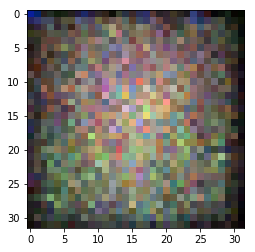

Train Epoch: 70 [0/50000 (0%)]	Loss: 0.001216
Train Epoch: 70 [6400/50000 (13%)]	Loss: 0.002170
Train Epoch: 70 [12800/50000 (26%)]	Loss: 0.001060
Train Epoch: 70 [19200/50000 (38%)]	Loss: 0.001129
Train Epoch: 70 [25600/50000 (51%)]	Loss: 0.000748
Train Epoch: 70 [32000/50000 (64%)]	Loss: 0.001260
Train Epoch: 70 [38400/50000 (77%)]	Loss: 0.001433
Train Epoch: 70 [44800/50000 (90%)]	Loss: 0.001839

Test set: Average loss: 0.0079, Accuracy: 8658/10000 (86%)

min [[[0.95486385]]]
max [[[1.8562574]]]


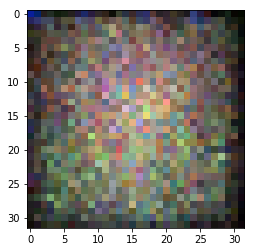

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.001721
Train Epoch: 71 [6400/50000 (13%)]	Loss: 0.001479
Train Epoch: 71 [12800/50000 (26%)]	Loss: 0.002644
Train Epoch: 71 [19200/50000 (38%)]	Loss: 0.000899
Train Epoch: 71 [25600/50000 (51%)]	Loss: 0.003228
Train Epoch: 71 [32000/50000 (64%)]	Loss: 0.000625
Train Epoch: 71 [38400/50000 (77%)]	Loss: 0.003050
Train Epoch: 71 [44800/50000 (90%)]	Loss: 0.003298

Test set: Average loss: 0.0078, Accuracy: 8674/10000 (86%)

min [[[0.9548964]]]
max [[[1.8565873]]]


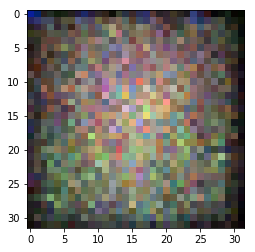

Train Epoch: 72 [0/50000 (0%)]	Loss: 0.001658
Train Epoch: 72 [6400/50000 (13%)]	Loss: 0.000820
Train Epoch: 72 [12800/50000 (26%)]	Loss: 0.002437
Train Epoch: 72 [19200/50000 (38%)]	Loss: 0.001111
Train Epoch: 72 [25600/50000 (51%)]	Loss: 0.001848
Train Epoch: 72 [32000/50000 (64%)]	Loss: 0.002564
Train Epoch: 72 [38400/50000 (77%)]	Loss: 0.002225
Train Epoch: 72 [44800/50000 (90%)]	Loss: 0.001699

Test set: Average loss: 0.0077, Accuracy: 8677/10000 (86%)

min [[[0.95492893]]]
max [[[1.8569186]]]


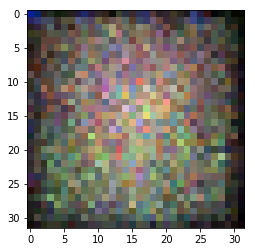

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.001295
Train Epoch: 73 [6400/50000 (13%)]	Loss: 0.001355
Train Epoch: 73 [12800/50000 (26%)]	Loss: 0.001626
Train Epoch: 73 [19200/50000 (38%)]	Loss: 0.001781
Train Epoch: 73 [25600/50000 (51%)]	Loss: 0.000850
Train Epoch: 73 [32000/50000 (64%)]	Loss: 0.001877
Train Epoch: 73 [38400/50000 (77%)]	Loss: 0.002022
Train Epoch: 73 [44800/50000 (90%)]	Loss: 0.001387

Test set: Average loss: 0.0078, Accuracy: 8680/10000 (86%)

min [[[0.9549619]]]
max [[[1.8572497]]]


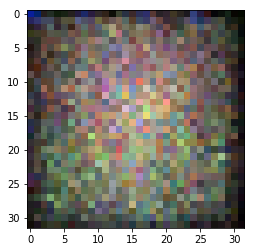

Train Epoch: 74 [0/50000 (0%)]	Loss: 0.002388
Train Epoch: 74 [6400/50000 (13%)]	Loss: 0.003436
Train Epoch: 74 [12800/50000 (26%)]	Loss: 0.003527
Train Epoch: 74 [19200/50000 (38%)]	Loss: 0.001664
Train Epoch: 74 [25600/50000 (51%)]	Loss: 0.002982
Train Epoch: 74 [32000/50000 (64%)]	Loss: 0.001879
Train Epoch: 74 [38400/50000 (77%)]	Loss: 0.002154
Train Epoch: 74 [44800/50000 (90%)]	Loss: 0.005707

Test set: Average loss: 0.0077, Accuracy: 8677/10000 (86%)

min [[[0.9549939]]]
max [[[1.8575839]]]


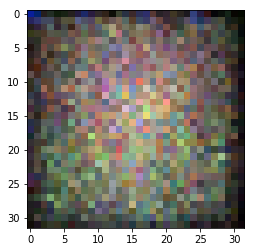

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.002616
Train Epoch: 75 [6400/50000 (13%)]	Loss: 0.001183
Train Epoch: 75 [12800/50000 (26%)]	Loss: 0.002232
Train Epoch: 75 [19200/50000 (38%)]	Loss: 0.003021
Train Epoch: 75 [25600/50000 (51%)]	Loss: 0.003075
Train Epoch: 75 [32000/50000 (64%)]	Loss: 0.001941
Train Epoch: 75 [38400/50000 (77%)]	Loss: 0.001099
Train Epoch: 75 [44800/50000 (90%)]	Loss: 0.001260

Test set: Average loss: 0.0079, Accuracy: 8654/10000 (86%)

min [[[0.95502526]]]
max [[[1.8579183]]]


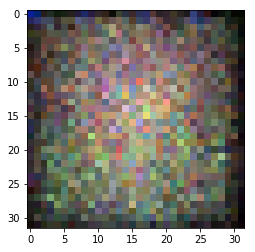

Train Epoch: 76 [0/50000 (0%)]	Loss: 0.001130
Train Epoch: 76 [6400/50000 (13%)]	Loss: 0.001455
Train Epoch: 76 [12800/50000 (26%)]	Loss: 0.001816
Train Epoch: 76 [19200/50000 (38%)]	Loss: 0.002720
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.001955
Train Epoch: 76 [32000/50000 (64%)]	Loss: 0.003344
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.001088
Train Epoch: 76 [44800/50000 (90%)]	Loss: 0.002142

Test set: Average loss: 0.0077, Accuracy: 8668/10000 (86%)

min [[[0.95505625]]]
max [[[1.8582517]]]


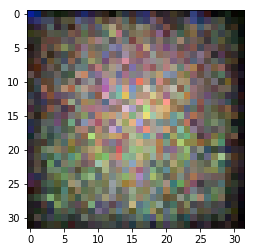

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.001550
Train Epoch: 77 [6400/50000 (13%)]	Loss: 0.001795
Train Epoch: 77 [12800/50000 (26%)]	Loss: 0.002331
Train Epoch: 77 [19200/50000 (38%)]	Loss: 0.001832
Train Epoch: 77 [25600/50000 (51%)]	Loss: 0.002484
Train Epoch: 77 [32000/50000 (64%)]	Loss: 0.001953
Train Epoch: 77 [38400/50000 (77%)]	Loss: 0.001037
Train Epoch: 77 [44800/50000 (90%)]	Loss: 0.001516

Test set: Average loss: 0.0077, Accuracy: 8686/10000 (86%)

min [[[0.95508766]]]
max [[[1.8585863]]]


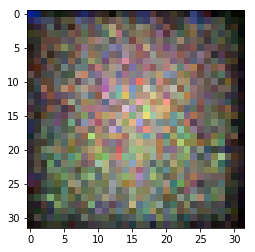

Train Epoch: 78 [0/50000 (0%)]	Loss: 0.006008
Train Epoch: 78 [6400/50000 (13%)]	Loss: 0.003352
Train Epoch: 78 [12800/50000 (26%)]	Loss: 0.002390
Train Epoch: 78 [19200/50000 (38%)]	Loss: 0.002156
Train Epoch: 78 [25600/50000 (51%)]	Loss: 0.001568
Train Epoch: 78 [32000/50000 (64%)]	Loss: 0.000949
Train Epoch: 78 [38400/50000 (77%)]	Loss: 0.000858
Train Epoch: 78 [44800/50000 (90%)]	Loss: 0.001867

Test set: Average loss: 0.0077, Accuracy: 8674/10000 (86%)

min [[[0.9551188]]]
max [[[1.8589221]]]


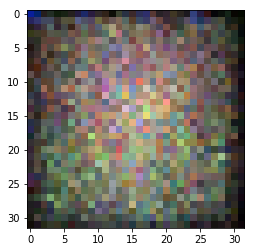

Train Epoch: 79 [0/50000 (0%)]	Loss: 0.000726
Train Epoch: 79 [6400/50000 (13%)]	Loss: 0.001304
Train Epoch: 79 [12800/50000 (26%)]	Loss: 0.001830
Train Epoch: 79 [19200/50000 (38%)]	Loss: 0.002014
Train Epoch: 79 [25600/50000 (51%)]	Loss: 0.001471
Train Epoch: 79 [32000/50000 (64%)]	Loss: 0.001297
Train Epoch: 79 [38400/50000 (77%)]	Loss: 0.001420
Train Epoch: 79 [44800/50000 (90%)]	Loss: 0.001325

Test set: Average loss: 0.0077, Accuracy: 8678/10000 (86%)

min [[[0.95514935]]]
max [[[1.8592582]]]


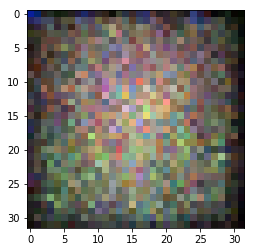

Train Epoch: 80 [0/50000 (0%)]	Loss: 0.002295
Train Epoch: 80 [6400/50000 (13%)]	Loss: 0.001559
Train Epoch: 80 [12800/50000 (26%)]	Loss: 0.001172
Train Epoch: 80 [19200/50000 (38%)]	Loss: 0.005136
Train Epoch: 80 [25600/50000 (51%)]	Loss: 0.001606
Train Epoch: 80 [32000/50000 (64%)]	Loss: 0.003124
Train Epoch: 80 [38400/50000 (77%)]	Loss: 0.001504
Train Epoch: 80 [44800/50000 (90%)]	Loss: 0.001207

Test set: Average loss: 0.0077, Accuracy: 8678/10000 (86%)

min [[[0.95518]]]
max [[[1.8595946]]]


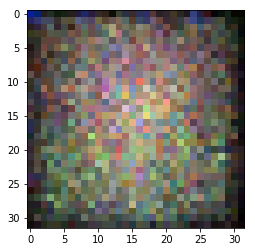

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.000933
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.001563
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.002558
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.003112
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.002235
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.001668
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.003131
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.008302

Test set: Average loss: 0.0077, Accuracy: 8674/10000 (86%)

min [[[0.9552104]]]
max [[[1.8599304]]]


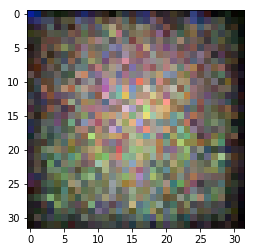

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.001594
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.002494
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.001526
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.001530
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.001822
Train Epoch: 82 [32000/50000 (64%)]	Loss: 0.001025
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.002192
Train Epoch: 82 [44800/50000 (90%)]	Loss: 0.002831

Test set: Average loss: 0.0076, Accuracy: 8680/10000 (86%)

min [[[0.9552404]]]
max [[[1.8602642]]]


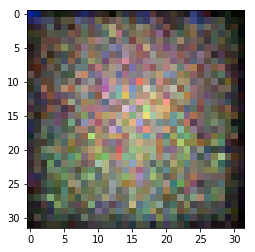

Train Epoch: 83 [0/50000 (0%)]	Loss: 0.001183
Train Epoch: 83 [6400/50000 (13%)]	Loss: 0.001638
Train Epoch: 83 [12800/50000 (26%)]	Loss: 0.001308
Train Epoch: 83 [19200/50000 (38%)]	Loss: 0.001379
Train Epoch: 83 [25600/50000 (51%)]	Loss: 0.001482
Train Epoch: 83 [32000/50000 (64%)]	Loss: 0.001655
Train Epoch: 83 [38400/50000 (77%)]	Loss: 0.001238
Train Epoch: 83 [44800/50000 (90%)]	Loss: 0.001986

Test set: Average loss: 0.0077, Accuracy: 8679/10000 (86%)

min [[[0.9552701]]]
max [[[1.8605971]]]


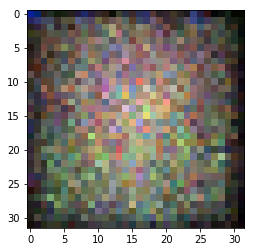

Train Epoch: 84 [0/50000 (0%)]	Loss: 0.001412
Train Epoch: 84 [6400/50000 (13%)]	Loss: 0.001446
Train Epoch: 84 [12800/50000 (26%)]	Loss: 0.001387
Train Epoch: 84 [19200/50000 (38%)]	Loss: 0.001730
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.002145
Train Epoch: 84 [32000/50000 (64%)]	Loss: 0.002104
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.001282
Train Epoch: 84 [44800/50000 (90%)]	Loss: 0.001764

Test set: Average loss: 0.0076, Accuracy: 8684/10000 (86%)

min [[[0.95530003]]]
max [[[1.8609298]]]


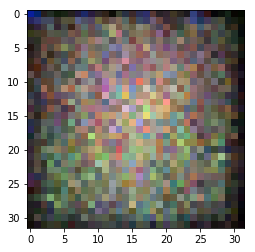

Train Epoch: 85 [0/50000 (0%)]	Loss: 0.001406
Train Epoch: 85 [6400/50000 (13%)]	Loss: 0.001609
Train Epoch: 85 [12800/50000 (26%)]	Loss: 0.000834
Train Epoch: 85 [19200/50000 (38%)]	Loss: 0.001046
Train Epoch: 85 [25600/50000 (51%)]	Loss: 0.000852
Train Epoch: 85 [32000/50000 (64%)]	Loss: 0.000775
Train Epoch: 85 [38400/50000 (77%)]	Loss: 0.004364
Train Epoch: 85 [44800/50000 (90%)]	Loss: 0.001184

Test set: Average loss: 0.0075, Accuracy: 8702/10000 (87%)

min [[[0.95532995]]]
max [[[1.8612646]]]


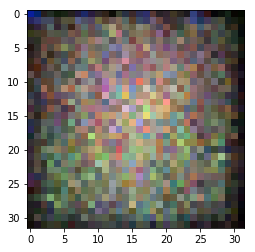

Train Epoch: 86 [0/50000 (0%)]	Loss: 0.001387
Train Epoch: 86 [6400/50000 (13%)]	Loss: 0.000814
Train Epoch: 86 [12800/50000 (26%)]	Loss: 0.002926
Train Epoch: 86 [19200/50000 (38%)]	Loss: 0.001164
Train Epoch: 86 [25600/50000 (51%)]	Loss: 0.001175
Train Epoch: 86 [32000/50000 (64%)]	Loss: 0.001492
Train Epoch: 86 [38400/50000 (77%)]	Loss: 0.001592
Train Epoch: 86 [44800/50000 (90%)]	Loss: 0.001490

Test set: Average loss: 0.0075, Accuracy: 8695/10000 (86%)

min [[[0.9553598]]]
max [[[1.8616008]]]


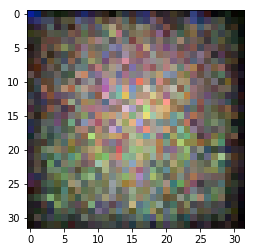

Train Epoch: 87 [0/50000 (0%)]	Loss: 0.001518
Train Epoch: 87 [6400/50000 (13%)]	Loss: 0.001709
Train Epoch: 87 [12800/50000 (26%)]	Loss: 0.002410
Train Epoch: 87 [19200/50000 (38%)]	Loss: 0.001915
Train Epoch: 87 [25600/50000 (51%)]	Loss: 0.001421
Train Epoch: 87 [32000/50000 (64%)]	Loss: 0.001572
Train Epoch: 87 [38400/50000 (77%)]	Loss: 0.001430
Train Epoch: 87 [44800/50000 (90%)]	Loss: 0.001252

Test set: Average loss: 0.0075, Accuracy: 8690/10000 (86%)

min [[[0.95538974]]]
max [[[1.8619363]]]


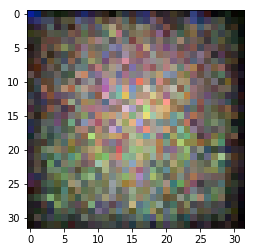

Train Epoch: 88 [0/50000 (0%)]	Loss: 0.001093
Train Epoch: 88 [6400/50000 (13%)]	Loss: 0.002932
Train Epoch: 88 [12800/50000 (26%)]	Loss: 0.007530
Train Epoch: 88 [19200/50000 (38%)]	Loss: 0.002399
Train Epoch: 88 [25600/50000 (51%)]	Loss: 0.001471
Train Epoch: 88 [32000/50000 (64%)]	Loss: 0.001703
Train Epoch: 88 [38400/50000 (77%)]	Loss: 0.000944
Train Epoch: 88 [44800/50000 (90%)]	Loss: 0.001259

Test set: Average loss: 0.0075, Accuracy: 8684/10000 (86%)

min [[[0.9554195]]]
max [[[1.8622714]]]


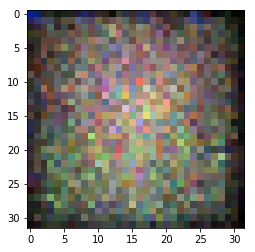

Train Epoch: 89 [0/50000 (0%)]	Loss: 0.002387
Train Epoch: 89 [6400/50000 (13%)]	Loss: 0.001208
Train Epoch: 89 [12800/50000 (26%)]	Loss: 0.002601
Train Epoch: 89 [19200/50000 (38%)]	Loss: 0.001032
Train Epoch: 89 [25600/50000 (51%)]	Loss: 0.001267
Train Epoch: 89 [32000/50000 (64%)]	Loss: 0.002895
Train Epoch: 89 [38400/50000 (77%)]	Loss: 0.003658
Train Epoch: 89 [44800/50000 (90%)]	Loss: 0.001815

Test set: Average loss: 0.0074, Accuracy: 8693/10000 (86%)

min [[[0.95544934]]]
max [[[1.8626059]]]


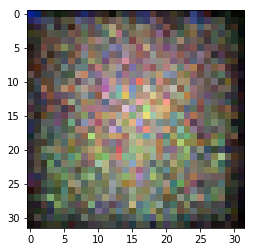

Train Epoch: 90 [0/50000 (0%)]	Loss: 0.000741
Train Epoch: 90 [6400/50000 (13%)]	Loss: 0.001478
Train Epoch: 90 [12800/50000 (26%)]	Loss: 0.001557
Train Epoch: 90 [19200/50000 (38%)]	Loss: 0.002567
Train Epoch: 90 [25600/50000 (51%)]	Loss: 0.002970
Train Epoch: 90 [32000/50000 (64%)]	Loss: 0.002054
Train Epoch: 90 [38400/50000 (77%)]	Loss: 0.001878
Train Epoch: 90 [44800/50000 (90%)]	Loss: 0.001191

Test set: Average loss: 0.0074, Accuracy: 8682/10000 (86%)

min [[[0.95547915]]]
max [[[1.8629411]]]


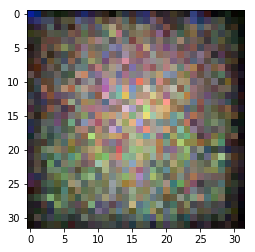

Train Epoch: 91 [0/50000 (0%)]	Loss: 0.001107
Train Epoch: 91 [6400/50000 (13%)]	Loss: 0.000892
Train Epoch: 91 [12800/50000 (26%)]	Loss: 0.000762
Train Epoch: 91 [19200/50000 (38%)]	Loss: 0.001509
Train Epoch: 91 [25600/50000 (51%)]	Loss: 0.001037
Train Epoch: 91 [32000/50000 (64%)]	Loss: 0.001103
Train Epoch: 91 [38400/50000 (77%)]	Loss: 0.001303
Train Epoch: 91 [44800/50000 (90%)]	Loss: 0.001560

Test set: Average loss: 0.0073, Accuracy: 8711/10000 (87%)

min [[[0.95547915]]]
max [[[1.8629662]]]


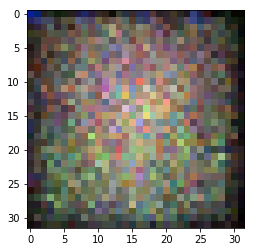

Train Epoch: 92 [0/50000 (0%)]	Loss: 0.006495
Train Epoch: 92 [6400/50000 (13%)]	Loss: 0.002739
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.001730
Train Epoch: 92 [19200/50000 (38%)]	Loss: 0.001367
Train Epoch: 92 [25600/50000 (51%)]	Loss: 0.000815
Train Epoch: 92 [32000/50000 (64%)]	Loss: 0.001035
Train Epoch: 92 [38400/50000 (77%)]	Loss: 0.001463
Train Epoch: 92 [44800/50000 (90%)]	Loss: 0.001814

Test set: Average loss: 0.0073, Accuracy: 8704/10000 (87%)

min [[[0.95547915]]]
max [[[1.8629909]]]


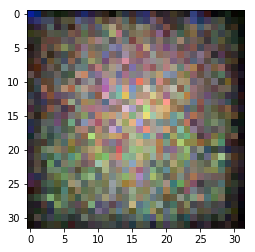

Train Epoch: 93 [0/50000 (0%)]	Loss: 0.008006
Train Epoch: 93 [6400/50000 (13%)]	Loss: 0.001966
Train Epoch: 93 [12800/50000 (26%)]	Loss: 0.001393
Train Epoch: 93 [19200/50000 (38%)]	Loss: 0.001814
Train Epoch: 93 [25600/50000 (51%)]	Loss: 0.000948
Train Epoch: 93 [32000/50000 (64%)]	Loss: 0.002117
Train Epoch: 93 [38400/50000 (77%)]	Loss: 0.001856
Train Epoch: 93 [44800/50000 (90%)]	Loss: 0.000995

Test set: Average loss: 0.0074, Accuracy: 8705/10000 (87%)

min [[[0.95547915]]]
max [[[1.8630154]]]


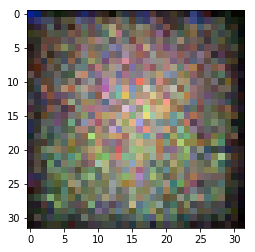

Train Epoch: 94 [0/50000 (0%)]	Loss: 0.001607
Train Epoch: 94 [6400/50000 (13%)]	Loss: 0.000907
Train Epoch: 94 [12800/50000 (26%)]	Loss: 0.001942
Train Epoch: 94 [19200/50000 (38%)]	Loss: 0.001352
Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.001072
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.000699
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.000986
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.001477

Test set: Average loss: 0.0075, Accuracy: 8674/10000 (86%)

min [[[0.95547915]]]
max [[[1.86304]]]


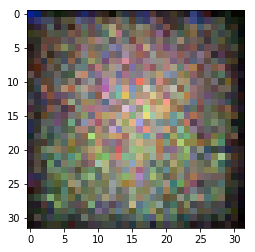

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.002275
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.005627
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.001701
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.000865
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.001565
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.001992
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.001052
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.000813

Test set: Average loss: 0.0074, Accuracy: 8692/10000 (86%)

min [[[0.95547915]]]
max [[[1.863065]]]


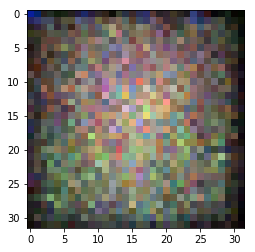

Train Epoch: 96 [0/50000 (0%)]	Loss: 0.001266
Train Epoch: 96 [6400/50000 (13%)]	Loss: 0.001706
Train Epoch: 96 [12800/50000 (26%)]	Loss: 0.001804
Train Epoch: 96 [19200/50000 (38%)]	Loss: 0.001575
Train Epoch: 96 [25600/50000 (51%)]	Loss: 0.000964
Train Epoch: 96 [32000/50000 (64%)]	Loss: 0.002030
Train Epoch: 96 [38400/50000 (77%)]	Loss: 0.001329
Train Epoch: 96 [44800/50000 (90%)]	Loss: 0.002126

Test set: Average loss: 0.0074, Accuracy: 8702/10000 (87%)

min [[[0.95547915]]]
max [[[1.8630898]]]


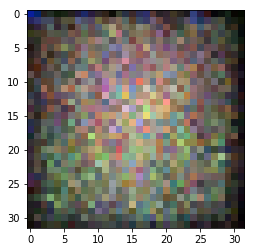

Train Epoch: 97 [0/50000 (0%)]	Loss: 0.002363
Train Epoch: 97 [6400/50000 (13%)]	Loss: 0.001004
Train Epoch: 97 [12800/50000 (26%)]	Loss: 0.001627
Train Epoch: 97 [19200/50000 (38%)]	Loss: 0.001118
Train Epoch: 97 [25600/50000 (51%)]	Loss: 0.001033
Train Epoch: 97 [32000/50000 (64%)]	Loss: 0.000984
Train Epoch: 97 [38400/50000 (77%)]	Loss: 0.003702
Train Epoch: 97 [44800/50000 (90%)]	Loss: 0.001022

Test set: Average loss: 0.0074, Accuracy: 8700/10000 (87%)

min [[[0.95547915]]]
max [[[1.8631146]]]


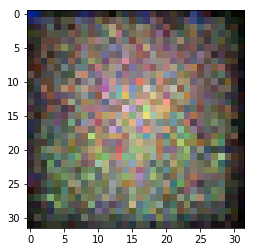

Train Epoch: 98 [0/50000 (0%)]	Loss: 0.001442
Train Epoch: 98 [6400/50000 (13%)]	Loss: 0.000743
Train Epoch: 98 [12800/50000 (26%)]	Loss: 0.001121
Train Epoch: 98 [19200/50000 (38%)]	Loss: 0.001689
Train Epoch: 98 [25600/50000 (51%)]	Loss: 0.001398
Train Epoch: 98 [32000/50000 (64%)]	Loss: 0.001492
Train Epoch: 98 [38400/50000 (77%)]	Loss: 0.001313
Train Epoch: 98 [44800/50000 (90%)]	Loss: 0.003283

Test set: Average loss: 0.0075, Accuracy: 8694/10000 (86%)

min [[[0.95547915]]]
max [[[1.8631392]]]


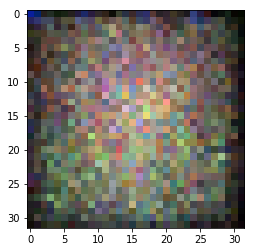

Train Epoch: 99 [0/50000 (0%)]	Loss: 0.001870
Train Epoch: 99 [6400/50000 (13%)]	Loss: 0.003361
Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.002859
Train Epoch: 99 [19200/50000 (38%)]	Loss: 0.000754
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.002208
Train Epoch: 99 [32000/50000 (64%)]	Loss: 0.004760
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.001328
Train Epoch: 99 [44800/50000 (90%)]	Loss: 0.001536

Test set: Average loss: 0.0074, Accuracy: 8695/10000 (86%)

min [[[0.95547915]]]
max [[[1.863164]]]


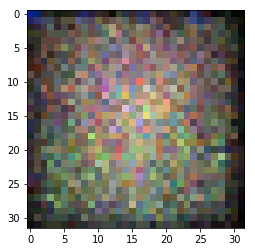

Train Epoch: 100 [0/50000 (0%)]	Loss: 0.001298
Train Epoch: 100 [6400/50000 (13%)]	Loss: 0.002661
Train Epoch: 100 [12800/50000 (26%)]	Loss: 0.001221
Train Epoch: 100 [19200/50000 (38%)]	Loss: 0.001076
Train Epoch: 100 [25600/50000 (51%)]	Loss: 0.001528
Train Epoch: 100 [32000/50000 (64%)]	Loss: 0.001586
Train Epoch: 100 [38400/50000 (77%)]	Loss: 0.001532
Train Epoch: 100 [44800/50000 (90%)]	Loss: 0.001647

Test set: Average loss: 0.0075, Accuracy: 8687/10000 (86%)

min [[[0.95547915]]]
max [[[1.8631889]]]


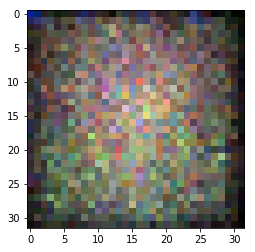

Train Epoch: 101 [0/50000 (0%)]	Loss: 0.001515
Train Epoch: 101 [6400/50000 (13%)]	Loss: 0.002326
Train Epoch: 101 [12800/50000 (26%)]	Loss: 0.001824
Train Epoch: 101 [19200/50000 (38%)]	Loss: 0.001623
Train Epoch: 101 [25600/50000 (51%)]	Loss: 0.001648
Train Epoch: 101 [32000/50000 (64%)]	Loss: 0.001512
Train Epoch: 101 [38400/50000 (77%)]	Loss: 0.001699
Train Epoch: 101 [44800/50000 (90%)]	Loss: 0.001247

Test set: Average loss: 0.0074, Accuracy: 8707/10000 (87%)

min [[[0.95547915]]]
max [[[1.8632135]]]


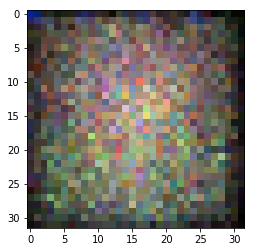

Train Epoch: 102 [0/50000 (0%)]	Loss: 0.001411
Train Epoch: 102 [6400/50000 (13%)]	Loss: 0.002067
Train Epoch: 102 [12800/50000 (26%)]	Loss: 0.002700
Train Epoch: 102 [19200/50000 (38%)]	Loss: 0.001619
Train Epoch: 102 [25600/50000 (51%)]	Loss: 0.000944
Train Epoch: 102 [32000/50000 (64%)]	Loss: 0.001008
Train Epoch: 102 [38400/50000 (77%)]	Loss: 0.002355
Train Epoch: 102 [44800/50000 (90%)]	Loss: 0.001788

Test set: Average loss: 0.0074, Accuracy: 8696/10000 (86%)

min [[[0.95547915]]]
max [[[1.8632388]]]


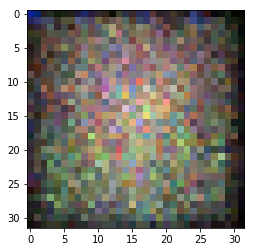

Train Epoch: 103 [0/50000 (0%)]	Loss: 0.003781
Train Epoch: 103 [6400/50000 (13%)]	Loss: 0.001515
Train Epoch: 103 [12800/50000 (26%)]	Loss: 0.000850
Train Epoch: 103 [19200/50000 (38%)]	Loss: 0.001535
Train Epoch: 103 [25600/50000 (51%)]	Loss: 0.002997
Train Epoch: 103 [32000/50000 (64%)]	Loss: 0.001318
Train Epoch: 103 [38400/50000 (77%)]	Loss: 0.001710
Train Epoch: 103 [44800/50000 (90%)]	Loss: 0.001555

Test set: Average loss: 0.0074, Accuracy: 8702/10000 (87%)

min [[[0.95547915]]]
max [[[1.8632649]]]


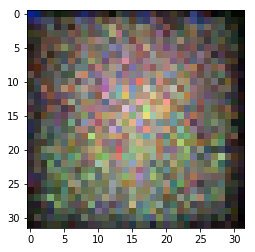

Train Epoch: 104 [0/50000 (0%)]	Loss: 0.002579
Train Epoch: 104 [6400/50000 (13%)]	Loss: 0.001169
Train Epoch: 104 [12800/50000 (26%)]	Loss: 0.001745
Train Epoch: 104 [19200/50000 (38%)]	Loss: 0.001664
Train Epoch: 104 [25600/50000 (51%)]	Loss: 0.001813
Train Epoch: 104 [32000/50000 (64%)]	Loss: 0.000558
Train Epoch: 104 [38400/50000 (77%)]	Loss: 0.001796
Train Epoch: 104 [44800/50000 (90%)]	Loss: 0.001495

Test set: Average loss: 0.0074, Accuracy: 8717/10000 (87%)

min [[[0.95547915]]]
max [[[1.8632914]]]


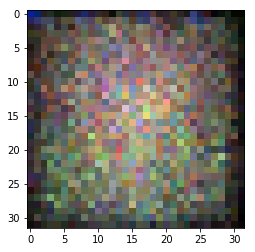

Train Epoch: 105 [0/50000 (0%)]	Loss: 0.001690
Train Epoch: 105 [6400/50000 (13%)]	Loss: 0.001397
Train Epoch: 105 [12800/50000 (26%)]	Loss: 0.000813
Train Epoch: 105 [19200/50000 (38%)]	Loss: 0.001081
Train Epoch: 105 [25600/50000 (51%)]	Loss: 0.001254
Train Epoch: 105 [32000/50000 (64%)]	Loss: 0.004413
Train Epoch: 105 [38400/50000 (77%)]	Loss: 0.001235
Train Epoch: 105 [44800/50000 (90%)]	Loss: 0.001508

Test set: Average loss: 0.0074, Accuracy: 8700/10000 (87%)

min [[[0.95547915]]]
max [[[1.8633175]]]


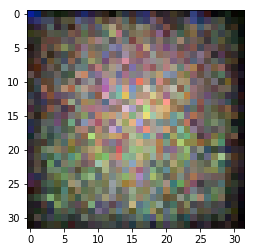

Train Epoch: 106 [0/50000 (0%)]	Loss: 0.001637
Train Epoch: 106 [6400/50000 (13%)]	Loss: 0.001077
Train Epoch: 106 [12800/50000 (26%)]	Loss: 0.001389
Train Epoch: 106 [19200/50000 (38%)]	Loss: 0.007395
Train Epoch: 106 [25600/50000 (51%)]	Loss: 0.000883
Train Epoch: 106 [32000/50000 (64%)]	Loss: 0.001465
Train Epoch: 106 [38400/50000 (77%)]	Loss: 0.001482
Train Epoch: 106 [44800/50000 (90%)]	Loss: 0.001019

Test set: Average loss: 0.0074, Accuracy: 8708/10000 (87%)

min [[[0.95547915]]]
max [[[1.8633436]]]


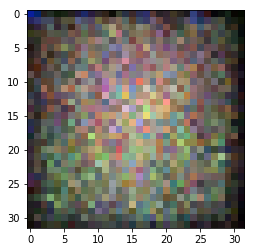

Train Epoch: 107 [0/50000 (0%)]	Loss: 0.003686
Train Epoch: 107 [6400/50000 (13%)]	Loss: 0.001276
Train Epoch: 107 [12800/50000 (26%)]	Loss: 0.001675
Train Epoch: 107 [19200/50000 (38%)]	Loss: 0.001390
Train Epoch: 107 [25600/50000 (51%)]	Loss: 0.001512
Train Epoch: 107 [32000/50000 (64%)]	Loss: 0.002366
Train Epoch: 107 [38400/50000 (77%)]	Loss: 0.001182
Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.002347

Test set: Average loss: 0.0074, Accuracy: 8682/10000 (86%)

min [[[0.95547915]]]
max [[[1.8633697]]]


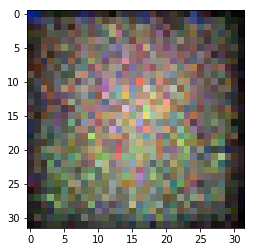

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.001814
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.001562
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.001764
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.001618
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.001605
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.001716
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.001983
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.001647

Test set: Average loss: 0.0072, Accuracy: 8710/10000 (87%)

min [[[0.95547915]]]
max [[[1.8633959]]]


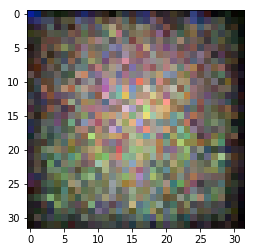

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.001162
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.002366
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.001787
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.001690
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.003110
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.002736
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.001233
Train Epoch: 109 [44800/50000 (90%)]	Loss: 0.001891

Test set: Average loss: 0.0073, Accuracy: 8713/10000 (87%)

min [[[0.95547915]]]
max [[[1.8634223]]]


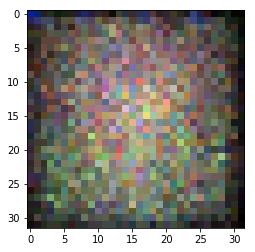

Train Epoch: 110 [0/50000 (0%)]	Loss: 0.001711
Train Epoch: 110 [6400/50000 (13%)]	Loss: 0.001693
Train Epoch: 110 [12800/50000 (26%)]	Loss: 0.001233
Train Epoch: 110 [19200/50000 (38%)]	Loss: 0.002915
Train Epoch: 110 [25600/50000 (51%)]	Loss: 0.001240
Train Epoch: 110 [32000/50000 (64%)]	Loss: 0.001311
Train Epoch: 110 [38400/50000 (77%)]	Loss: 0.001105
Train Epoch: 110 [44800/50000 (90%)]	Loss: 0.002012

Test set: Average loss: 0.0075, Accuracy: 8687/10000 (86%)

min [[[0.95547915]]]
max [[[1.8634485]]]


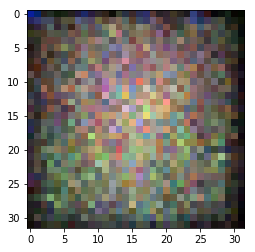

Train Epoch: 111 [0/50000 (0%)]	Loss: 0.001292
Train Epoch: 111 [6400/50000 (13%)]	Loss: 0.001096
Train Epoch: 111 [12800/50000 (26%)]	Loss: 0.001463
Train Epoch: 111 [19200/50000 (38%)]	Loss: 0.001944
Train Epoch: 111 [25600/50000 (51%)]	Loss: 0.001058
Train Epoch: 111 [32000/50000 (64%)]	Loss: 0.001139
Train Epoch: 111 [38400/50000 (77%)]	Loss: 0.001447
Train Epoch: 111 [44800/50000 (90%)]	Loss: 0.002647

Test set: Average loss: 0.0073, Accuracy: 8711/10000 (87%)

min [[[0.95547915]]]
max [[[1.8634746]]]


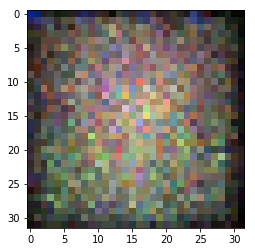

Train Epoch: 112 [0/50000 (0%)]	Loss: 0.001882
Train Epoch: 112 [6400/50000 (13%)]	Loss: 0.001357
Train Epoch: 112 [12800/50000 (26%)]	Loss: 0.002563
Train Epoch: 112 [19200/50000 (38%)]	Loss: 0.002028
Train Epoch: 112 [25600/50000 (51%)]	Loss: 0.001895
Train Epoch: 112 [32000/50000 (64%)]	Loss: 0.001845
Train Epoch: 112 [38400/50000 (77%)]	Loss: 0.001199
Train Epoch: 112 [44800/50000 (90%)]	Loss: 0.001553

Test set: Average loss: 0.0074, Accuracy: 8676/10000 (86%)

min [[[0.95547915]]]
max [[[1.8635008]]]


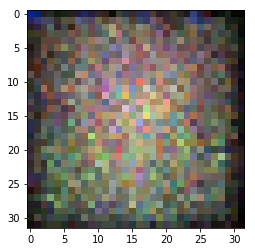

Train Epoch: 113 [0/50000 (0%)]	Loss: 0.001967
Train Epoch: 113 [6400/50000 (13%)]	Loss: 0.001177
Train Epoch: 113 [12800/50000 (26%)]	Loss: 0.002240
Train Epoch: 113 [19200/50000 (38%)]	Loss: 0.001499
Train Epoch: 113 [25600/50000 (51%)]	Loss: 0.002386
Train Epoch: 113 [32000/50000 (64%)]	Loss: 0.001208
Train Epoch: 113 [38400/50000 (77%)]	Loss: 0.001456
Train Epoch: 113 [44800/50000 (90%)]	Loss: 0.005920

Test set: Average loss: 0.0074, Accuracy: 8703/10000 (87%)

min [[[0.95547915]]]
max [[[1.863527]]]


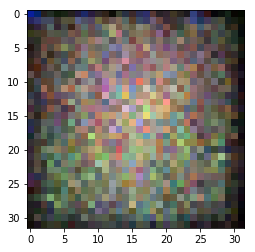

Train Epoch: 114 [0/50000 (0%)]	Loss: 0.001785
Train Epoch: 114 [6400/50000 (13%)]	Loss: 0.000963
Train Epoch: 114 [12800/50000 (26%)]	Loss: 0.002434
Train Epoch: 114 [19200/50000 (38%)]	Loss: 0.001432
Train Epoch: 114 [25600/50000 (51%)]	Loss: 0.001883
Train Epoch: 114 [32000/50000 (64%)]	Loss: 0.001207
Train Epoch: 114 [38400/50000 (77%)]	Loss: 0.001929
Train Epoch: 114 [44800/50000 (90%)]	Loss: 0.002353

Test set: Average loss: 0.0073, Accuracy: 8700/10000 (87%)

min [[[0.95547915]]]
max [[[1.8635535]]]


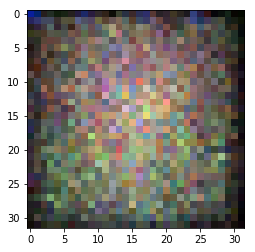

Train Epoch: 115 [0/50000 (0%)]	Loss: 0.001230
Train Epoch: 115 [6400/50000 (13%)]	Loss: 0.001001
Train Epoch: 115 [12800/50000 (26%)]	Loss: 0.003401
Train Epoch: 115 [19200/50000 (38%)]	Loss: 0.001390
Train Epoch: 115 [25600/50000 (51%)]	Loss: 0.000946
Train Epoch: 115 [32000/50000 (64%)]	Loss: 0.002924
Train Epoch: 115 [38400/50000 (77%)]	Loss: 0.001183
Train Epoch: 115 [44800/50000 (90%)]	Loss: 0.002915

Test set: Average loss: 0.0073, Accuracy: 8716/10000 (87%)

min [[[0.95547915]]]
max [[[1.8635796]]]


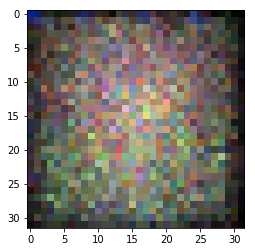

Train Epoch: 116 [0/50000 (0%)]	Loss: 0.001450
Train Epoch: 116 [6400/50000 (13%)]	Loss: 0.000991
Train Epoch: 116 [12800/50000 (26%)]	Loss: 0.001767
Train Epoch: 116 [19200/50000 (38%)]	Loss: 0.001492
Train Epoch: 116 [25600/50000 (51%)]	Loss: 0.002111
Train Epoch: 116 [32000/50000 (64%)]	Loss: 0.002549
Train Epoch: 116 [38400/50000 (77%)]	Loss: 0.001892
Train Epoch: 116 [44800/50000 (90%)]	Loss: 0.001634

Test set: Average loss: 0.0073, Accuracy: 8709/10000 (87%)

min [[[0.95547915]]]
max [[[1.8636056]]]


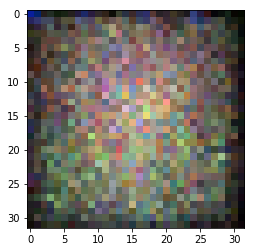

Train Epoch: 117 [0/50000 (0%)]	Loss: 0.000860
Train Epoch: 117 [6400/50000 (13%)]	Loss: 0.001512
Train Epoch: 117 [12800/50000 (26%)]	Loss: 0.001565
Train Epoch: 117 [19200/50000 (38%)]	Loss: 0.001758
Train Epoch: 117 [25600/50000 (51%)]	Loss: 0.001052
Train Epoch: 117 [32000/50000 (64%)]	Loss: 0.001359
Train Epoch: 117 [38400/50000 (77%)]	Loss: 0.000637
Train Epoch: 117 [44800/50000 (90%)]	Loss: 0.001755

Test set: Average loss: 0.0074, Accuracy: 8692/10000 (86%)

min [[[0.95547915]]]
max [[[1.8636318]]]


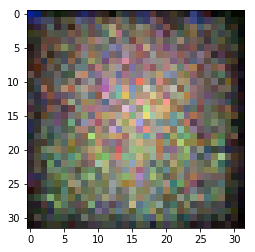

Train Epoch: 118 [0/50000 (0%)]	Loss: 0.001544
Train Epoch: 118 [6400/50000 (13%)]	Loss: 0.002863
Train Epoch: 118 [12800/50000 (26%)]	Loss: 0.002723
Train Epoch: 118 [19200/50000 (38%)]	Loss: 0.000945
Train Epoch: 118 [25600/50000 (51%)]	Loss: 0.001433
Train Epoch: 118 [32000/50000 (64%)]	Loss: 0.001365
Train Epoch: 118 [38400/50000 (77%)]	Loss: 0.002246
Train Epoch: 118 [44800/50000 (90%)]	Loss: 0.001577

Test set: Average loss: 0.0073, Accuracy: 8708/10000 (87%)

min [[[0.95547915]]]
max [[[1.8636583]]]


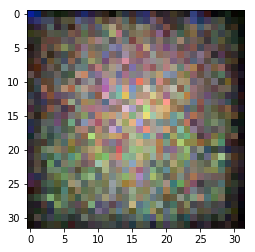

Train Epoch: 119 [0/50000 (0%)]	Loss: 0.001303
Train Epoch: 119 [6400/50000 (13%)]	Loss: 0.001070
Train Epoch: 119 [12800/50000 (26%)]	Loss: 0.001494
Train Epoch: 119 [19200/50000 (38%)]	Loss: 0.002532
Train Epoch: 119 [25600/50000 (51%)]	Loss: 0.002404
Train Epoch: 119 [32000/50000 (64%)]	Loss: 0.001170
Train Epoch: 119 [38400/50000 (77%)]	Loss: 0.001217
Train Epoch: 119 [44800/50000 (90%)]	Loss: 0.002914

Test set: Average loss: 0.0075, Accuracy: 8691/10000 (86%)

min [[[0.95547915]]]
max [[[1.8636845]]]


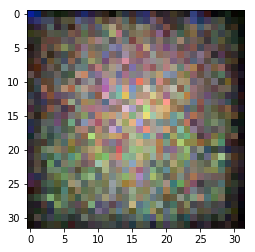

Train Epoch: 120 [0/50000 (0%)]	Loss: 0.001074
Train Epoch: 120 [6400/50000 (13%)]	Loss: 0.003909
Train Epoch: 120 [12800/50000 (26%)]	Loss: 0.002285
Train Epoch: 120 [19200/50000 (38%)]	Loss: 0.001528
Train Epoch: 120 [25600/50000 (51%)]	Loss: 0.001295
Train Epoch: 120 [32000/50000 (64%)]	Loss: 0.001015
Train Epoch: 120 [38400/50000 (77%)]	Loss: 0.001526
Train Epoch: 120 [44800/50000 (90%)]	Loss: 0.002237

Test set: Average loss: 0.0073, Accuracy: 8707/10000 (87%)

min [[[0.95547915]]]
max [[[1.8637106]]]


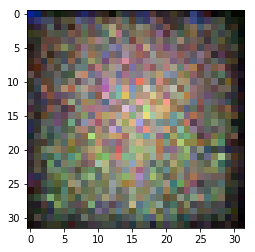

Train Epoch: 121 [0/50000 (0%)]	Loss: 0.001054
Train Epoch: 121 [6400/50000 (13%)]	Loss: 0.001430
Train Epoch: 121 [12800/50000 (26%)]	Loss: 0.001767
Train Epoch: 121 [19200/50000 (38%)]	Loss: 0.002297
Train Epoch: 121 [25600/50000 (51%)]	Loss: 0.001477
Train Epoch: 121 [32000/50000 (64%)]	Loss: 0.001203
Train Epoch: 121 [38400/50000 (77%)]	Loss: 0.001108
Train Epoch: 121 [44800/50000 (90%)]	Loss: 0.001184

Test set: Average loss: 0.0073, Accuracy: 8707/10000 (87%)



In [20]:
for epoch in range(1, 122):
    scheduler.step()
    train(epoch)
    test()
    if epoch%30==0:
        lr_noise.data=lr_noise.data/10
        save_model(model,model_path)
        state = {'acc': acc, 'noise': noise_input_conv}
        torch.save(state, './../My_Tutorial/data/cifar_data/checkpoint/state_with_noise_v1.h5')

In [30]:
save_model(model,model_path)
state = {'acc': acc, 'noise': noise_input_conv}
torch.save(state, './../My_Tutorial/data/cifar_data/checkpoint/state_with_noise_ckpt5.h5')

In [18]:
#When loading a previously trained model 'noise_v1.h5'  and its corresponsing noise template learnt
state= torch.load('./../My_Tutorial/data/cifar_data/checkpoint/state_with_noise_v1.h5')
noise_input_conv = state['noise']
acc = state['acc']
test()

/data/pandap/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':



Test set: Average loss: 0.0073, Accuracy: 8707/10000 (87%)



min [[[0.95547915]]]
max [[[1.8637106]]]


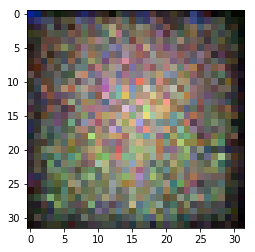

In [19]:
mean_noise_image = torch.mean(noise_input_conv, 0, True)
min_val = torch.min(mean_noise_image.data)
My_imshow_noise(mean_noise_image.data[0,:,:,:] )

### Note, mean_noise will be used during testing / evaluation

torch.Size([1, 3, 32, 32])
min [[[0.95547915]]]
max [[[1.8637106]]]


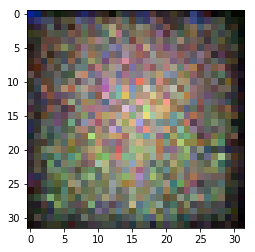

min [[[-1.5589118]]]
max [[[1.6679429]]]


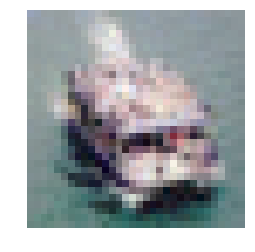

In [20]:
mean_noise = torch.mean(noise_input_conv, 0, True) 
print(mean_noise.size())
min_val = torch.min(mean_noise_image.data)
My_imshow_noise(mean_noise_image.data[0,:,:,:])
#My_imshow(mean_noise.data[0,:,:,:])
plt.ioff()
plt.show()
plt.figure()
My_imshow_noise(torchvision.utils.make_grid(images[0,:,:,:]*(mean_noise.data[0,:,:,:])))
# show_landmarks_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()

# Adverserial Attacks
## Load source model for Blackbox attack in model_new

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model_new=ResNet18()

In [22]:
model_new_path = './../My_Tutorial/data/cifar_data/checkpoint/No_noise_ckpt4_lrstep.h5'
load_model(model_new, model_new_path)
model_new = model_new.cuda()

In [23]:
# Generate adeversial for test_loader
images, labels = next(dataiter)
inp_var = Variable(images.cuda(), requires_grad = True)
true_label= Variable(labels.cuda(), requires_grad = False)

In [24]:
inp_var_perp = Variable(images.cuda(), requires_grad = True)

# Loss Surface Calculation

In [25]:
#only for floating point range values of eps
def g_loss(EPS1, EPS2):
    g_loss_val = np.zeros([8,8])
    output_perp = model_new(inp_var_perp) #output = model_new(torch.unsqueeze(inp_var[1,:,:,:], 0)) for just one input
    output_par = model(inp_var, mean_noise.cuda())
    loss_ad_perp = criterion(output_perp, true_label)
    loss_ad_perp.backward() #obtain gradient on inp_var
    loss_ad_par = criterion(output_par, true_label)
    loss_ad_par.backward() #obtain gradient on inp_var
 # Add perturbation for untargeted attack where AIM is to misclassify adversary <whereas in targeted
 # aim is to misclassify adversary as particular target
    inp_var_grad_par   = torch.sign(inp_var.grad.data)
    inp_var_grad_perp   = torch.sign(inp_var_perp.grad.data)
    for eps1 in np.arange(0,4,0.5):
        for eps2 in np.arange(0,4,0.5):
            total_adv_perp = eps1/10 * inp_var_grad_par
            total_adv_par = eps2/10 * inp_var_grad_perp
            inp_adversarial = inp_var.data + total_adv_perp.cuda() + total_adv_par.cuda()
            image_adv = inp_adversarial.cpu()
            out_adv = model(Variable(inp_adversarial), mean_noise.cuda())
            loss_adv_target = criterion(out_adv, true_label)
            i=int(eps1*2)
            j=int(eps2*2)
            g_loss_val[i][j] = loss_adv_target.data.cpu().numpy()
    return g_loss_val

In [26]:
eps_1 = np.arange(0,4,0.5)/10
eps_2 = np.arange(0,4,0.5)/10
EPS1, EPS2 = np.meshgrid(eps_1, eps_2)
#len(EPS2[0])
loss_val =g_loss(EPS1, EPS2)

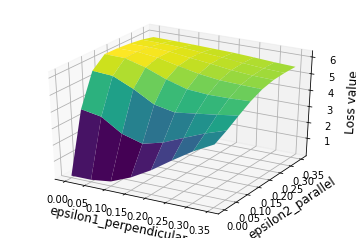

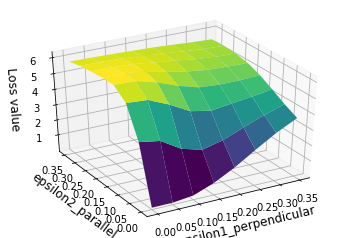

In [27]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(EPS1, EPS2, loss_val,1000)
ax.plot_surface(EPS1, EPS2, loss_val, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('epsilon1_perpendicular', fontsize='large') # Blackbox attack direction
ax.set_ylabel('epsilon2_parallel',fontsize='large') # Whitebox attack direction
ax.set_zlabel('Loss value',fontsize='large');
plt.show()
fig
ax.view_init(35, -120)
fig

# Adversarial Dimension Calculation

In [28]:
false_list_256=[]
dataiter = iter(test_loader)

## Run the three cells (Cell A, Cell B, Cell C) below 6 times to calculate avearage of 6*64 images for adversarial dimensionality

min [[[-0.9137255]]]
max [[[1.0313725]]]


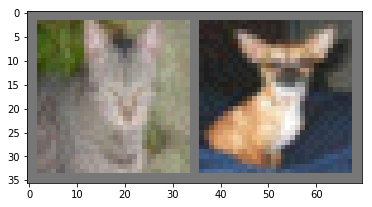

In [58]:
 # Cell A
images, labels = dataiter.next()
inp_var = Variable(images.cuda(), requires_grad = True)
true_label= Variable(labels.cuda(), requires_grad = False)
output = model_new(inp_var)
#output = model(inp_var, mean_noise.cuda())
loss_ad = criterion(output, true_label)
loss_ad.backward() #obtain gradient on inp_var
epsilon = 8/255 
inp_var_grad   = torch.sign(inp_var.grad.data)
inp_adversarial = inp_var.data + epsilon * inp_var_grad
image_adv = inp_adversarial.cpu()
plt.figure()
My_imshow_noise(torchvision.utils.make_grid(image_adv[0:2,:,:,:]))

In [59]:
#Cell B
from scipy.linalg import hadamard
num_dir =np.array([1,4,8,16,32,64,128])
false_list=[]
for i in range(len(num_dir)):
    num_chunks = int(3072/num_dir[i])

    r_dir = hadamard(num_dir[i])
#print(r_dir.shape)
    r_inp = np.zeros([num_dir[i],3,32,32])
    for j in range(0,num_dir[i]):
        r_inp[j,:,:,:] = np.tile(r_dir[j,:],num_chunks).reshape(3,32,32)
    r_final=np.zeros([batch_size,num_dir[i],3,32,32])
    for k in range(batch_size):
        r_final[k,:,:,:,:] = r_inp * inp_var_grad[k,:,:,:] * epsilon   
    false_match1 = np.zeros(num_dir[i])
    for l in range(num_dir[i]):
        inp_adv = inp_var.data.cpu().numpy() + r_final[:,l,:,:,:]
        inp_adv = torch.Tensor(inp_adv)
        y_pred_adversarial = np.argmax(model(Variable(inp_adv).cuda(),mean_noise.cuda()).data.cpu().numpy(), axis =1)
        count = 0
        for m in range(batch_size):
            if y_pred_adversarial[m]!=labels[m]:
                count = count +1
    #print('False match:',count)
        false_match1[l] = count
    false_list.append(np.mean(false_match1)/64)
#print(r_inp.shape)

In [60]:
#Cell C
false_list_256.append(false_list)

In [62]:
false_list_256

[[0.234375,
  0.16796875,
  0.158203125,
  0.150390625,
  0.150390625,
  0.1474609375,
  0.146240234375],
 [0.078125,
  0.07421875,
  0.076171875,
  0.0751953125,
  0.07421875,
  0.07373046875,
  0.073974609375],
 [0.234375,
  0.1796875,
  0.171875,
  0.1669921875,
  0.162109375,
  0.15966796875,
  0.1588134765625],
 [0.203125,
  0.15234375,
  0.146484375,
  0.1484375,
  0.14697265625,
  0.146728515625,
  0.147705078125],
 [0.234375,
  0.15234375,
  0.13671875,
  0.1279296875,
  0.125,
  0.124755859375,
  0.1240234375],
 [0.203125,
  0.15234375,
  0.1484375,
  0.14453125,
  0.14013671875,
  0.1396484375,
  0.139404296875]]

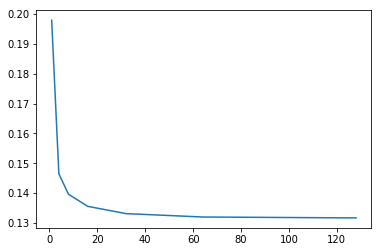

In [67]:
a_sum = np.sum(false_list_256, axis=0)/6
x1=np.array([1,4,8,16,32,64,128])
y1=np.array(a_sum)
plt.plot(x1,y1)

In [64]:
state={'x':x1, 'y':y1}
torch.save(state,'./../My_Tutorial/data/cifar_data/checkpoint/Adv_space_NoL_epslion_8.h5')

# Attack Methods and Adversarial Accuracy Calculation

### FGSM attack -Whitebox

In [29]:
# WITH CUDA Add SINGLE_STEP perturbation cross entropy loss
correct_count = 0
correct_count_orig = 0
non_targeted = True
epsilon = 8/255

for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model(inp_var, mean_noise.cuda())
        y_pred_orig=  output.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)
                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv
        else:
            inp_adversarial = inp_var.data - total_adv
        y_prob = model(Variable(inp_adversarial).cuda(), mean_noise.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()

print('Clean accuracy *100:',correct_count_orig)
print('Adversarial accuracy *100:',correct_count)

Clean accuracy *100: tensor(8707)
Adversarial accuracy *100: tensor(3343)


#Note  all Blackbox attacks are created from source model (trained with SGD)- model_new loaded from No_noise_ckpt4_lrstep.h5 in cell number 20, 21 above

### FGSM attack - Blackbox

In [30]:
# WITH CUDA Add SINGLE_STEP perturbation cross entropy loss
correct_count = 0
correct_count_orig = 0
non_targeted = True
epsilon = 8/255
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs

        inputs, labels_tru = data
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model_new(inp_var)
        with torch.no_grad():
            output_target = model(inp_var, mean_noise.cuda())
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)

                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv
        else:
            inp_adversarial = inp_var.data - total_adv
        y_prob = model(Variable(inp_adversarial).cuda(), mean_noise.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        
print('Clean accuracy *100:',correct_count_orig)
print('Adversarial accuracy *100:',correct_count)

Clean accuracy *100: tensor(8707)
Adversarial accuracy *100: tensor(8123)


### PGD attack- Whitebox

In [30]:
# Add ITERATIVE PGD perturbation 
correct_count = 0
correct_count_orig = 0
epsilon = 8/255
num_steps=7
alpha = 2/255
num_classes = 10
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        

        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        with torch.no_grad():
            output_target = model(inp_var, mean_noise.cuda())
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
         # Add ITERATIVE perturbation
        step =0
        inp_adv = Variable((inp_var.data.cpu() + (2* epsilon*torch.rand(inp_var.data.size())
                                           - epsilon)).cuda(), requires_grad = True) 
        while step < num_steps:
            output = model(inp_adv, mean_noise.cuda())
            loss_ad = criterion(output, true_label)
            loss_ad.backward() #obtain gradient on inp_var
            eta = alpha * torch.sign(inp_adv.grad.data)
            eta = torch.clamp(eta, -epsilon, epsilon)
            inp_adv.data += eta
            step +=1
            
        y_prob = model(inp_adv.cuda(), mean_noise.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        

print('Clean accuracy:',correct_count_orig) #Note, divide by 100 for % accuracy
print('Adversarial accuracy:',correct_count) #Note, divide by 100 for % accuracy

Clean accuracy: tensor(8707)
Adversarial accuracy: tensor(884)


### PGD attack- Blackbox

In [31]:
# Add ITERATIVE PGD perturbation 
correct_count = 0
correct_count_orig = 0
epsilon = 8/255
num_steps=7
alpha = 2/255
num_classes = 10
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        

        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        with torch.no_grad():
            output_target = model(inp_var, mean_noise.cuda())
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
         # Add ITERATIVE perturbation
        step =0
        inp_adv = Variable((inp_var.data.cpu() + (2* epsilon*torch.rand(inp_var.data.size())
                                           - epsilon)).cuda(), requires_grad = True) 
        while step < num_steps:
            output = model_new(inp_adv)
            loss_ad = criterion(output, true_label)
            loss_ad.backward() #obtain gradient on inp_var
            eta = alpha * torch.sign(inp_adv.grad.data)
            eta = torch.clamp(eta, -epsilon, epsilon)
            inp_adv.data += eta
            step +=1
            
        y_prob = model(inp_adv.cuda(), mean_noise.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        #stop+=1
        

print('Clean accuracy:',correct_count_orig) #Note, divide by 100 for % accuracy
print('Adversarial accuracy:',correct_count) #Note, divide by 100 for % accuracy

Clean accuracy: tensor(8707)
Adversarial accuracy: tensor(7212)


# PC Analysis

### Intermediate PCA for more data

In [31]:
res18_model = model
res18_model_conv1 = nn.Sequential(*list(res18_model.children())[0:2])
for param in res18_model_conv1.parameters():
    param.requires_grad=False
    
res18_model_bl1 = nn.Sequential(*list(res18_model.children())[2:3])
for param in res18_model_bl1.parameters():
    param.requires_grad=False
    
res18_model_bl2 = nn.Sequential(*list(res18_model.children())[3:4])
for param in res18_model_bl2.parameters():
    param.requires_grad=False
    
res18_model_bl3 = nn.Sequential(*list(res18_model.children())[4:5])
for param in res18_model_bl3.parameters():
    param.requires_grad=False

res18_model_bl4 = nn.Sequential(*list(res18_model.children())[5:6])
for param in res18_model_bl4.parameters():
    param.requires_grad=False
    
res18_model_linear= nn.Sequential(*list(res18_model.children())[-1:])
for param in res18_model_linear.parameters():
    param.requires_grad=False

In [32]:
x_vec=[]
x_vec_adv=[]
x_vec_advinp=[]
x_vec_inp=[]
x_vec_label=[]
dataiter = iter(test_loader)

### N = 64*11 for doing PC experiments

In [33]:
for i in range(0,11):
    correct_count = 0
    correct_count_orig = 0
    non_targeted = True
    epsilon = 8/255
    stop =0

    while(stop==0):
        # get the inputs
        inputs, labels_tru = dataiter.next() #data
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model_new(inp_var)
        y_pred_orig=  output.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)
        else:
            true_label.data= output.data.max(1)[1]
            loss_ad = criterion(output, true_label)
                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv
        else:
            inp_adversarial = inp_var.data - total_adv
        #total_adv
        inp_adversarial = torch.clamp(inp_adversarial, -1.5, 1.5)
        y_prob = model(Variable(inp_adversarial).cuda(), mean_noise.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        stop+=1
    inputs = inputs * mean_noise.data
    inp_var, label_var = Variable(inputs.cuda()), Variable(labels.cuda())
    outputs_conv1=res18_model_conv1(inp_var)
    #outputs_bl1 = res18_model_bl1(Variable((outputs_conv1.data)))
    x_c_pc = outputs_conv1.data.cpu()
    x_c_pc = x_c_pc[:,:,:,:].numpy().reshape((-1,64*32*32))
    x_vec.append(x_c_pc)
    
    x_c_inp=inputs.numpy().reshape(-1,32*32*3)
    x_vec_inp.append(x_c_inp)
    x_c_inpadv=(inp_adversarial.cpu()).numpy().reshape(-1,32*32*3)
    x_vec_advinp.append(x_c_inpadv)
    x_vec_label.append(labels_tru.numpy().reshape(-1))

    outputs_conv1_adv=res18_model_conv1(Variable(inp_adversarial.cpu() * mean_noise.data).cuda())
    #outputs_bl1_adv = res18_model_bl1(Variable((outputs_conv1_adv.data.cpu().cuda())))
    x_c_pc_adv = outputs_conv1_adv.data.cpu()
    x_c_pc_adv = x_c_pc_adv[:,:,:,:].numpy().reshape((-1,64*32*32))
    x_vec_adv.append(x_c_pc_adv)

### PC variance calculation for Conv1 layer of ResNet18 in response to clean inputs

In [34]:
from sklearn.decomposition import PCA
ar= np.array(x_vec)
ar = ar.reshape(11*64, 64*32*32)
mean_pc= np.mean(ar, axis=0)
pca1 = PCA()
pca1.fit(ar-mean_pc)
pc_sc1 = pca1.explained_variance_ratio_
c_eig = sorted(pc_sc1, reverse=True)

Text(0,0.5,'% Cumulative Variance')

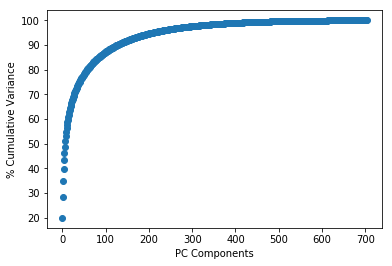

In [35]:
fig = plt.figure()
n_PC = len(c_eig)
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(211)
tot = sum(c_eig)
var_exp = [(i/tot)*100 for i in c_eig[0:n_PC]]
cum_var_exp = np.cumsum(var_exp)
trace2 = plt.scatter(
        x=[i for i in range(0,n_PC)], y=cum_var_exp)
#plt.plot([62, 62], [98, 102], 'k-', lw=4)
ax.set_xlabel('PC Components')
ax.set_ylabel('% Cumulative Variance')

#### Variance for PC1 - PC100 for clean data response at Conv1 layer of ResNet18

In [36]:
val = sum(c_eig[0:100]/tot)
print(val)

0.8703189846128225


### PC variance calculation for Conv1 layer of ResNet18 in response to adversarial inputs

In [37]:
from sklearn.decomposition import PCA
ar1= np.array(x_vec_adv)
ar1 = ar1.reshape(11*64, 64*32*32)
mean_pc_adv= np.mean(ar1, axis=0)
pca2 = PCA()
pca2.fit(ar1-mean_pc_adv)
pc_sc2 = pca2.explained_variance_ratio_
c_eig_adv = sorted(pc_sc2, reverse=True)

Text(0,0.5,'% Cumulative Variance')

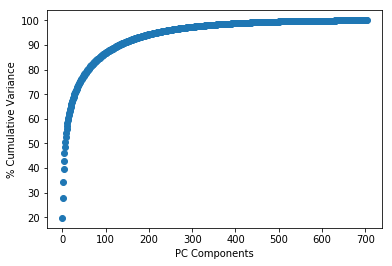

In [38]:
fig = plt.figure()
n_PC = len(c_eig_adv)
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(211)
tot = sum(c_eig_adv)
var_exp = [(j/tot)*100 for j in c_eig_adv[0:n_PC]]
cum_var_exp = np.cumsum(var_exp)
trace2 = plt.scatter(
        x=[i for i in range(0,n_PC)], y=cum_var_exp)
#plt.plot([62, 62], [98, 102], 'k-', lw=4)
ax.set_xlabel('PC Components')
ax.set_ylabel('% Cumulative Variance')

#### Variance for PC1 - PC100 for adversarial data response at Conv1 layer of ResNet18

In [39]:
val = sum(c_eig_adv[0:100]/tot)
print(val)

0.8664577737217769


In [40]:
x_clean_t = pca1.fit_transform(ar-mean_pc) #Clean PC projections of Conv1 Layer activations
x_adv_t = pca2.fit_transform(ar1-mean_pc_adv) #Adversarial PC projections of Conv1 Layer activations

Text(0,0.5,'PC 1')

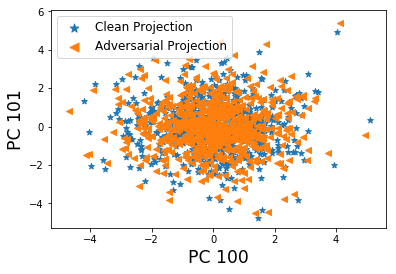

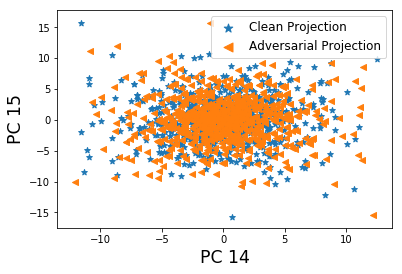

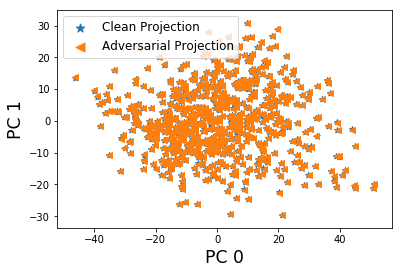

In [41]:
final = 100
high=14
low=0

plt.scatter( x=x_clean_t[:,final],
        y=x_clean_t[:,final+1],marker='*')#, c=np.array(x_vec_label).reshape(11*64), edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10))

plt.scatter( x=x_adv_t[:,final],
        y=x_adv_t[:,final+1],marker='<')#,c=np.array(x_vec_label).reshape(11*64), edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10))
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5, fontsize = 'large')
plt.xlabel('PC 100',fontsize = 'xx-large')
plt.ylabel('PC 101',fontsize = 'xx-large')
plt.figure()

plt.scatter( x=x_clean_t[:,high],
        y=x_clean_t[:,high+1],marker='*')#, c=np.array(x_vec_label).reshape(11*64), edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10))

plt.scatter( x=x_adv_t[:,high],
        y=x_adv_t[:,high+1],marker='<')#,c=np.array(x_vec_label).reshape(11*64), edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10))
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5, fontsize = 'large')
plt.xlabel('PC 14',fontsize = 'xx-large')
plt.ylabel('PC 15',fontsize = 'xx-large')
plt.figure()

plt.scatter( x=x_clean_t[:,low],
        y=x_clean_t[:,low+1],marker='*')
    #plt.figure()
plt.scatter( x=x_adv_t[:,low],
        y=x_adv_t[:,low+1],marker='<')
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5,fontsize = 'large')
plt.xlabel('PC 0',fontsize = 'xx-large')
plt.ylabel('PC 1',fontsize = 'xx-large')

In [42]:
state = {'x_adv_t': x_adv_t, 'x_clean_t': x_clean_t}
torch.save(state, './../My_Tutorial/data/cifar_data/checkpoint/PC_dim_NoL.h5')

## Cosine distance between adversarial and clean response PC components at Conv1 of ResNet18

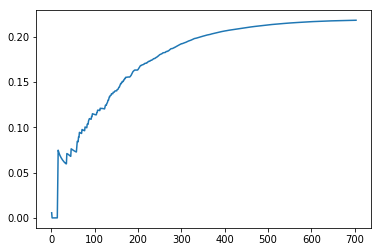

In [43]:
import scipy
dist_high=np.zeros(704)
for high in range(0,704):
    dist_high_x=0
    for i in range(0,704):
        dist_high_x += (scipy.spatial.distance.pdist(np.array((x_adv_t[i,0:high],
                                                          x_clean_t[i,0:high])), 'cosine'))
    dist_high[high]=np.mean(dist_high_x/704)
plt.plot(np.arange(0,704), dist_high)